In [185]:
%load_ext rpy2.ipython
import rpy2.robjects.lib.ggplot2 as ggplot2
import childespy
import numpy as np
import os
import imp
import pandas as pd
import transformers
import torch
import scipy.stats
import copy
from string import punctuation

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
#how many single-xxx, multi-xxx, and no-xxx child utterances are in Providence? 
# how many tokens does the first case correspond to
# of these, how many are monosyllabic phono vs. multi-syllabic phono

In [1413]:
pvd_idx = childespy.get_sql_query('select * from corpus where name = "Providence"').iloc[0]['id']

R[write to console]: Using current database version: '2020.1'.



In [1415]:
phono_glosses = childespy.get_sql_query('select gloss, target_child_name, target_child_age, \
    speaker_code, actual_phonology, model_phonology, transcript_id, utterance_id, \
    token_order, corpus_name, collection_name, language from token where \
    actual_phonology != "" and model_phonology != "" and collection_name = "Eng-NA" \
    and corpus_id = '+str(pvd_idx) ,
        db_version = "2020.1")

R[write to console]: Using supported database version: '2020.1'.



In [1429]:
phono_glosses.corpus_name.value_counts()

Providence    396621
Name: corpus_name, dtype: int64

In [1417]:
phono_glosses.loc[phono_glosses.gloss == 'xxx'].actual_phonology.value_counts()

*       26736
ə          10
(.)         7
aɪ          4
ən          2
        ...  
dulɪ        1
əno         1
wɛ          1
iəɪs        1
faɪ         1
Name: actual_phonology, Length: 76, dtype: int64

Actual phonology is almost always * for xxx items

In [1418]:
phono_glosses.loc[phono_glosses.gloss == 'yyy'].actual_phonology.value_counts()

ɛ        3206
ʌ        2132
ɪ        1881
ə         512
o         507
         ... 
dɪhʊ        1
dʊ^də       1
ɛso         1
ɡʌɑd        1
wʌtɪs       1
Name: actual_phonology, Length: 30293, dtype: int64

Actual phonology is populated for yyy items

In [1419]:
chi_phono = phono_glosses.loc[(phono_glosses.speaker_code == 'CHI') & 
    (phono_glosses.target_child_age < (365*5))]

In [1420]:
def count_transmission_errors(utt_vector, error_codes):
    return(np.sum([x in error_codes for x in  utt_vector]))

In [1421]:
xxxs_per_utt = chi_phono.groupby('utterance_id').gloss.agg(
    lambda x: count_transmission_errors(x, ['xxx'])).reset_index()
xxxs_per_utt.columns = ['utterance_id', 'num_xxx']
yyys_per_utt = chi_phono.groupby('utterance_id').gloss.agg(
    lambda x: count_transmission_errors(x, ['yyy'])).reset_index()
yyys_per_utt.columns = ['utterance_id', 'num_yyy']
failures_per_utt = xxxs_per_utt.merge(yyys_per_utt)

In [1422]:
yyy_utts = failures_per_utt.loc[(failures_per_utt.num_xxx == 0) &  (failures_per_utt.num_yyy == 1)]

In [1423]:
yyy_utts.shape

(31457, 3)

In [1424]:
success_utts = failures_per_utt.loc[(failures_per_utt.num_xxx == 0) &  
    (failures_per_utt.num_yyy == 0)]

In [1425]:
success_utts.shape

(83880, 3)

In [169]:
tokens_from_errorless_utts = chi_phono.loc[chi_phono.utterance_id.isin(success_utts.utterance_id)]

In [1426]:
excludes = ['*','(.)','(..)', '(...)','(....)','(.....)']
tokens_from_errorless_utts = tokens_from_errorless_utts.loc[~(tokens_from_errorless_utts.actual_phonology.isin(excludes) |
    tokens_from_errorless_utts.model_phonology.isin(excludes))]

In [1427]:
tokens_from_errorless_utts.shape

(271272, 13)

In [1428]:
tokens_from_errorless_utts.actual_phonology

103469            ə
103470           ðæ
103471           aj
103472           aj
103473           aj
            ...    
458551        θʊtin
458552    fɜ˞rzdeɪː
458553     fɜ˞rsdeɪ
458554     hɜ˞rzdeɪ
458555         fʌ̃m
Name: actual_phonology, Length: 271272, dtype: object

In [ ]:
# 31,760 transmission errors (from 31,760 utterances)
# 271,272 transmission successes (from 111,812 utterances)

# Prevalence of communication failures by age 

In [91]:
error_codes = ('xxx','yyy','zzz')

In [108]:
chi_phono['target_child_age_months'] = chi_phono.target_child_age / 30.5

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [142]:
error_prop_per_transcript = chi_phono.groupby('transcript_id').gloss.agg(lambda x:
        sum(np.array([y in error_codes for y in x]) / len(x))).reset_index()
error_prop_per_transcript.columns = ['transcript_id', 'proportion_errors']
age_per_transcript = chi_phono.groupby('transcript_id').target_child_age_months.agg(np.unique).reset_index()                    
tokens_per_transcript = chi_phono.groupby('transcript_id').target_child_age_months.agg(np.size).reset_index()                    
tokens_per_transcript.columns = ['transcript_id', 'num_tokens']
corpusname_for_transcript = chi_phono.groupby('transcript_id').corpus_name.agg(np.unique).reset_index()
error_prop_per_transcript = error_prop_per_transcript.merge(age_per_transcript).merge(
    tokens_per_transcript).merge(corpusname_for_transcript)
error_prop_per_transcript.head(5)
%R -i error_prop_per_transcript

In [143]:
error_prop_per_transcript.columns

Index(['transcript_id', 'proportion_errors', 'target_child_age_months',
       'num_tokens', 'corpus_name'],
      dtype='object')

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



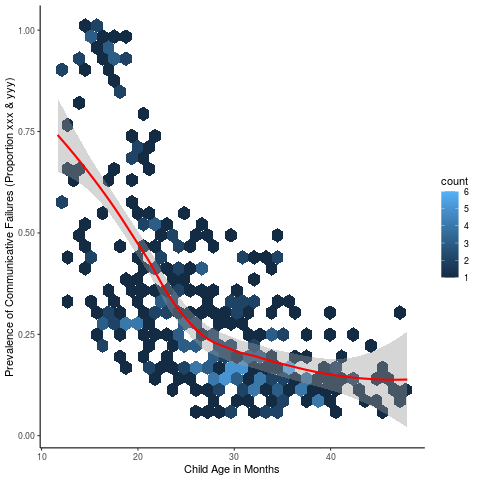

In [177]:
%%R 
ggplot(subset(error_prop_per_transcript,target_child_age_months < 48
    & num_tokens > 20 & corpus_name == 'Providence')) + geom_hex(aes(x=target_child_age_months, 
y=proportion_errors)) + theme_classic() + xlab('Child Age in Months') + ylab(
'Prevalence of Communicative Failures (Proportion xxx & yyy)') + stat_smooth(
aes(x=target_child_age_months,  y=proportion_errors), color= 'red')

In [130]:
## why are there 0-prop ones so early? What are these transcripts?
error_prop_per_transcript.loc[(error_prop_per_transcript.target_child_age_months < 20)
    & (error_prop_per_transcript.proportion_errors == 0) & (error_prop_per_transcript.num_tokens
    > 20 )]

,transcript_id,proportion_errors,target_child_age_months,num_tokens
61,41294,0.0,19.991803,23.0
714,42662,0.0,19.452869,42.0
716,42664,0.0,19.518443,25.0
718,42666,0.0,19.584016,23.0
725,42673,0.0,19.780738,23.0
726,42674,0.0,19.959016,26.0
1068,43017,0.0,17.883197,21.0
1073,43022,0.0,18.225410,23.0
1088,43037,0.0,19.551230,35.0
1415,43369,0.0,15.526639,33.0


In [132]:
chi_phono.loc[chi_phono.transcript_id == 41294]

,gloss,target_child_name,target_child_age,speaker_code,actual_phonology,model_phonology,transcript_id,utterance_id,token_order,corpus_name,collection_name,language,target_child_age_months
119198,bike,E,609.75,CHI,bakʰ,baɪk,41294,16647109,1,Inkelas,Eng-NA,eng,19.991803
120983,bee,E,609.75,CHI,biː,biː,41294,16647219,1,Inkelas,Eng-NA,eng,19.991803
138605,bus,E,609.75,CHI,bʌʂ,bʌs,41294,16647048,1,Inkelas,Eng-NA,eng,19.991803
154932,duck,E,609.75,CHI,kʰʌk,dʌk,41294,16647271,1,Inkelas,Eng-NA,eng,19.991803
163119,foot,E,609.75,CHI,fʊtʰ,fʊt,41294,16647129,1,Inkelas,Eng-NA,eng,19.991803
178427,helmet,E,609.75,CHI,hɛmi,hɛlmət,41294,16647099,1,Inkelas,Eng-NA,eng,19.991803
179090,Henry,E,609.75,CHI,hɛni,hɛnɹiː,41294,16647066,1,Inkelas,Eng-NA,eng,19.991803
202640,yuck,E,609.75,CHI,jʌkʰ,jʌk,41294,16647075,1,Inkelas,Eng-NA,eng,19.991803
202641,yuck,E,609.75,CHI,ʌkʰ,jʌk,41294,16647089,1,Inkelas,Eng-NA,eng,19.991803
210371,caboose,E,609.75,CHI,ʌbuəʂ,kəbuːs,41294,16647023,1,Inkelas,Eng-NA,eng,19.991803


In [136]:
error_prop_per_transcript.loc[(error_prop_per_transcript.target_child_age_months < 24)
    & (error_prop_per_transcript.proportion_errors > .95) &  (error_prop_per_transcript.num_tokens > 20)]

,transcript_id,proportion_errors,target_child_age_months,num_tokens
264,42205,0.957921,17.358607,404.0
266,42207,0.984102,18.422131,629.0
368,42309,0.987281,14.889344,629.0
369,42310,0.964765,15.723361,596.0
370,42311,0.972868,15.395492,774.0
371,42312,0.995136,15.821721,1028.0
533,42474,1.000000,14.430328,187.0
534,42475,1.000000,15.264344,278.0
535,42476,0.996466,15.821721,283.0
536,42477,1.000000,16.196721,72.0


In [137]:
chi_phono.loc[chi_phono.transcript_id == 42205]

,gloss,target_child_name,target_child_age,speaker_code,actual_phonology,model_phonology,transcript_id,utterance_id,token_order,corpus_name,collection_name,language,target_child_age_months
389,yyy,Alex,529.4375,CHI,ʌ̃,*,42205,16759608,1,Providence,Eng-NA,eng,17.358607
390,yyy,Alex,529.4375,CHI,ɡæpɪð,*,42205,16759608,2,Providence,Eng-NA,eng,17.358607
391,yyy,Alex,529.4375,CHI,ʌ,*,42205,16759643,1,Providence,Eng-NA,eng,17.358607
392,yyy,Alex,529.4375,CHI,ɪ,*,42205,16759643,2,Providence,Eng-NA,eng,17.358607
393,yyy,Alex,529.4375,CHI,ɪ,*,42205,16759643,3,Providence,Eng-NA,eng,17.358607
...,...,...,...,...,...,...,...,...,...,...,...,...,...
319216,wee,Alex,529.4375,CHI,wiːɪ,wiː,42205,16760372,1,Providence,Eng-NA,eng,17.358607
319217,wee,Alex,529.4375,CHI,wiː,wiː,42205,16763775,1,Providence,Eng-NA,eng,17.358607
319218,wee,Alex,529.4375,CHI,wiː,wiː,42205,16764496,1,Providence,Eng-NA,eng,17.358607
329275,water,Alex,529.4375,CHI,ʌːdɜ˞,wɑtəɹ,42205,16764283,1,Providence,Eng-NA,eng,17.358607


### Test for monosyllabicity

In [ ]:
# 2 options: 
# 1. look for 2 or more sections of Vs separate by Cs; alternatively, 
    # this requires dealing with this long tail of rare IPA; maybe figure out how to map from IPA
    # to CMU citation forms
# 2. Look the gloss up in a syllabified dictionary (this already reflects the )

In [150]:
tokens_from_pvd = chi_phono.loc[(chi_phono.transcript_id.isin(error_prop_per_transcript.loc
    [error_prop_per_transcript.corpus_name == "Providence"].transcript_id))]

In [151]:
tokens_from_pvd.shape

(396621, 13)

In [178]:
# get the phoneme inventory from actual phonology and 
ipa_chars = set(list(
    ' '.join(np.unique(tokens_from_errorless_utts.model_phonology)) +
    ' '.join(np.unique(tokens_from_errorless_utts.actual_phonology))
))
print(' '.join(ipa_chars))

. ɖ ɞ v ɱ ç ˞ ʊ ̰ ɬ ɶ ̚ ^ y V ŋ ʰ k ̞ ɐ ʷ ɦ ʍ ʉ ʦ ː ʤ ʒ ̘ h ɮ ɒ b l e ̆ w ʀ ɟ ɚ c ʑ q ð ̟ ɥ ͡ ɾ œ ˀ ̺ ̬ ɘ ɣ ʏ ɢ ̜ ɪ ɝ ̩ z ̵ ʣ g ʧ ɸ β j ʂ ɡ ɰ ˠ ɵ ʝ ̥ p u ʴ ʃ ̪ ɑ o d m ̯ ̣ ʌ ̤ ɻ n ʲ ʎ ˑ ̙ ɨ ɹ ˺ ́ ̹ ɫ a r ɲ ʙ ɜ ̠ ɯ ʁ ̂ t   ʈ θ f ɤ ̃ x χ ø ʔ ɕ i ̽ æ s ɛ ɔ ə ʋ


In [154]:
pvd_phoneme_prevalence = pd.Series(list(
    ' '.join(np.unique(tokens_from_pvd.model_phonology)) +
    ' '.join(np.unique(tokens_from_pvd.actual_phonology))
)).value_counts().reset_index()

,index,0
0,,71684
1,ɪ,33576
2,ə,24892
3,d,18894
4,i,18183
...,...,...
61,),2
62,ɱ,2
63,x,2
64,ɚ,1


In [ ]:
# Need to remap from the Phonbank phonology to a simplified phonology where I can use the PFST
# Simplified phonology will also make it easier to distinguish between consonants and vowels
# Want to measure the coverage of the model-based phonology and the actual phonology
# okay to throw away some data in this process


# Masked Language Prediction Softmax with BERT 

In [1643]:
from pytorch_pretrained_bert import BertForMaskedLM
from transformers import BertTokenizer

In [228]:
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)

<module 'transfomers_bert_completions' from '/home/stephan/notebooks/child-directed-listening/transfomers_bert_completions.py'>

In [342]:
bertMaskedLM = BertForMaskedLM.from_pretrained('bert-base-uncased')
bertMaskedLM.eval()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [229]:
transfomers_bert_completions.compare_completions("mommy [MASK] .", bertMaskedLM, tokenizer).head(10)

,prob,word,rank
999,0.043639,!,0
5222,0.018040,wins,1
8658,0.016046,feat,2
2293,0.013641,love,3
5285,0.011568,vol,4
5443,0.011388,vs,5
3336,0.011358,baby,6
2611,0.010932,girl,7
2879,0.006419,boy,8
10955,0.005327,sings,9


In [230]:
transfomers_bert_completions.compare_completions("where [MASK] ?", bertMaskedLM, tokenizer).head(10)

,prob,word,rank
2000,0.454888,to,0
2842,0.237073,else,1
2085,0.097786,now,2
2133,0.063521,...,3
2059,0.011167,then,4
1029,0.008017,?,5
3599,0.007931,exactly,6
2003,0.007056,is,7
2013,0.006340,from,8
1999,0.006288,in,9


In [231]:
transfomers_bert_completions.compare_completions("hi [MASK] .", bertMaskedLM, tokenizer).head(10)

,prob,word,rank
3217,0.034561,##ro,0
2721,0.027147,##la,1
2278,0.025326,##c,2
3600,0.023967,##ck,3
3630,0.022182,##no,4
3070,0.022060,##ng,5
17364,0.021378,##jack,6
3597,0.021141,##co,7
2527,0.020253,##ra,8
2140,0.019197,##l,9


In [232]:
transfomers_bert_completions.compare_completions("what [MASK] .", bertMaskedLM, tokenizer).head(10)

,prob,word,rank
2065,0.521930,if,0
3047,0.042963,happened,1
1996,0.039804,the,2
1029,0.026004,?,3
2085,0.018232,now,4
2720,0.017595,mr,5
1037,0.013899,a,6
2005,0.011796,for,7
2055,0.008336,about,8
2785,0.008206,kind,9


In [252]:
completions = transfomers_bert_completions.compare_completions("go [MASK] .", bertMaskedLM, tokenizer)

In [253]:
completions

,prob,word,rank
2006,1.638184e-01,on,0
3805,1.473298e-01,ahead,1
2185,1.082801e-01,away,2
2188,9.947739e-02,home,3
4095,3.158719e-02,##sh,4
...,...,...,...
27484,1.254488e-09,##pressive,30517
22934,1.206291e-09,##rigues,30518
28739,1.161330e-09,##ivar,30519
21525,1.075385e-09,##grove,30520


# Load Models

In [1984]:
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)

<module 'transfomers_bert_completions' from '/home/stephan/notebooks/child-directed-listening/transfomers_bert_completions.py'>

In [1957]:
cmu_in_childes = pd.read_csv('phon/cmu_in_childes.csv')

In [1963]:
cmu_2syl_inchildes = cmu_in_childes.loc[cmu_in_childes.num_vowels <=2]

In [1990]:
adult_bertMaskedLM = BertForMaskedLM.from_pretrained('bert-base-uncased')
adult_bertMaskedLM.eval()
adult_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
adult_softmax_mask, adult_vocab = transfomers_bert_completions.get_softmax_mask(adult_tokenizer, cmu_2syl_inchildes.word)

ft1_bertMaskedLM = BertForMaskedLM.from_pretrained('model_output')
ft1_bertMaskedLM.eval()
ft1_tokenizer = BertTokenizer.from_pretrained('model_output')
ft1_softmax_mask, ft1_vocab = transfomers_bert_completions.get_softmax_mask(ft1_tokenizer, cmu_2syl_inchildes.word)

ft2_bertMaskedLM = BertForMaskedLM.from_pretrained('model_output2')
ft2_bertMaskedLM.eval()
ft2_tokenizer = BertTokenizer.from_pretrained('model_output2')
ft2_softmax_mask, ft2_vocab = transfomers_bert_completions.get_softmax_mask(ft2_tokenizer, cmu_2syl_inchildes.word)

In [1991]:
print(len(ft2_vocab))
print(len(ft2_softmax_mask))

7904
7904


# Run Actual Sents Through BERT for Prediction

In [289]:
pvd_idx = childespy.get_sql_query('select * from corpus where name = "Providence"').iloc[0]['id']

R[write to console]: Using current database version: '2020.1'.



In [1614]:
regenerate = False

if regenerate:
    utt_glosses = childespy.get_sql_query('select gloss, transcript_id, id, \
    utterance_order, speaker_code, type from utterance where corpus_id = '+str(pvd_idx) ,
        db_version = "2020.1")
    utt_glosses.to_csv('csv/pvd_utt_glosses.csv', index=False)
else: 
    utt_glosses = pd.read_csv('csv/pvd_utt_glosses.csv')

In [1616]:
# would be better to split these glosses, but then we lose the alignment 
def fix_gloss(gloss):
    return(str(gloss).replace('+','').replace('_',''))

utt_glosses.gloss = [fix_gloss(x) for x in utt_glosses.gloss]

punct_for_type = {
    'question':'?',
    'declarative':'.',
    'self interruption':'.',
    'interruption':'!',
    'trail off':'...',
    'interruption question':'?',
    'trail off question':'?',
    'imperative_emphatic':'!' 
}

utt_glosses['punct'] = [punct_for_type[x] if x in punct_for_type else '.'
                        for x in utt_glosses.type ]

utt_glosses = utt_glosses.loc[[x is not None for x in utt_glosses.punct]]
utt_glosses['speaker_code_simple'] = ['[CHI]' if x == 'CHI' else '[CGV]'
    for x in utt_glosses.speaker_code]

utt_glosses['gloss_with_punct'] = [x['speaker_code_simple'] +' '+ x['gloss'].lower()+ x['punct'] for x in utt_glosses.to_dict('records')] 
utt_glosses.shape

(460061, 9)

In [1617]:
utt_glosses[utt_glosses.id == 17280964]

,gloss,transcript_id,id,utterance_order,speaker_code,type,punct,speaker_code_simple,gloss_with_punct
460056,oh why lick hippo,42569,17280964,756,CHI,self interruption,.,[CHI],[CHI] oh why lick hippo.


In [2081]:
### need the tokenizer corresponding to the model; note this has to come from 
# transformers, not masked language model scoring library, which will not include
# the additional defined types (yyy and xxx)
initial_tokenizer = BertTokenizer.from_pretrained('model_output2')
initial_tokenizer.add_tokens(['yyy','xxx']) #must maintain xxx and yyy for alignment
inital_vocab_mask, initial_vocab = transfomers_bert_completions.get_softmax_mask(initial_tokenizer,
    cmu_2syl_inchildes.word)

In [2343]:
cmu_in_initial_vocab = cmu_2syl_inchildes.loc[cmu_2syl_inchildes.word.isin(initial_vocab)]
cmu_in_initial_vocab.shape

(7904, 8)

In [2082]:
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)

<module 'transfomers_bert_completions' from '/home/stephan/notebooks/child-directed-listening/transfomers_bert_completions.py'>

In [1648]:
initial_tokenizer.tokenize('this is a yyy.')

['this', 'is', 'a', 'yyy', '.']

In [1649]:
# this is slow, because tokenization is slow
def inflate (row):
    tokens = initial_tokenizer.tokenize(row['gloss_with_punct'])
    return(pd.DataFrame({'token':tokens, 'id':row['id']}) )

regenerate = True
if regenerate:
    all_tokens = pd.concat([inflate(x) for x in utt_glosses.to_dict('records')])
    all_tokens = all_tokens.merge(utt_glosses)
    all_tokens.to_csv('csv/pvd_utt_glosses_inflated.csv')

else:
    all_tokens = pd.read_csv('csv/pvd_utt_glosses_inflated.csv', na_filter=False)

In [1650]:
all_tokens.iloc[1]

token                                              where
id                                              16759250
gloss                         where do you want me to go
transcript_id                                      42204
utterance_order                                        1
speaker_code                                         OPE
type                                            question
punct                                                  ?
speaker_code_simple                                [CGV]
gloss_with_punct       [CGV] where do you want me to go?
Name: 1, dtype: object

In [1651]:
all_tokens['token_id'] = initial_tokenizer.convert_tokens_to_ids(all_tokens['token'])
all_tokens['seq_utt_id'] = all_tokens['id'].astype('category').cat.codes

In [1652]:
all_tokens.loc[all_tokens.gloss_with_punct == "[CHI] what is this yyy."]

,token,id,gloss,transcript_id,utterance_order,speaker_code,type,punct,speaker_code_simple,gloss_with_punct,token_id,seq_utt_id
26822,[chi],16764425,what is this yyy,42211,343,CHI,declarative,.,[CHI],[CHI] what is this yyy.,30522,4645
26823,what,16764425,what is this yyy,42211,343,CHI,declarative,.,[CHI],[CHI] what is this yyy.,2054,4645
26824,is,16764425,what is this yyy,42211,343,CHI,declarative,.,[CHI],[CHI] what is this yyy.,2003,4645
26825,this,16764425,what is this yyy,42211,343,CHI,declarative,.,[CHI],[CHI] what is this yyy.,2023,4645
26826,yyy,16764425,what is this yyy,42211,343,CHI,declarative,.,[CHI],[CHI] what is this yyy.,30524,4645
26827,.,16764425,what is this yyy,42211,343,CHI,declarative,.,[CHI],[CHI] what is this yyy.,1012,4645
31843,[chi],16765341,what is this yyy,42211,396,CHI,declarative,.,[CHI],[CHI] what is this yyy.,30522,5561
31844,what,16765341,what is this yyy,42211,396,CHI,declarative,.,[CHI],[CHI] what is this yyy.,2054,5561
31845,is,16765341,what is this yyy,42211,396,CHI,declarative,.,[CHI],[CHI] what is this yyy.,2003,5561
31846,this,16765341,what is this yyy,42211,396,CHI,declarative,.,[CHI],[CHI] what is this yyy.,2023,5561


### Add back IPA, syllable structure, and child ages for child productions

In [1661]:
pvd_chi_tokens = childespy.get_sql_query('select gloss, target_child_name, target_child_age, \
speaker_code, actual_phonology, model_phonology, transcript_id, utterance_id, \
token_order from token where speaker_code = "CHI" and corpus_id = '+str(pvd_idx),
    db_version = "2020.1")
pvd_chi_tokens['gloss'] = [fix_gloss(x) for x in pvd_chi_tokens.gloss]

R[write to console]: Using supported database version: '2020.1'.



In [1662]:
all_tokens_test = copy.deepcopy(all_tokens)

In [1663]:
all_tokens_test['actual_phonology'] = ''
all_tokens_test['model_phonology'] = ''
all_tokens_test['target_child_age'] = np.nan

In [1664]:
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)

<module 'transfomers_bert_completions' from '/home/stephan/notebooks/child-directed-listening/transfomers_bert_completions.py'>

In [1665]:
_, idx = np.unique(all_tokens_test.id, return_index=True)
all_utt_indices = all_tokens_test.id[np.sort(idx)]

In [1666]:
all_utt_indices[0:10]

0     16759250
9     16759261
19    16759270
27    16759279
31    16759300
41    16759315
44    16759322
51    16759330
63    16759342
70    16759353
Name: id, dtype: int64

In [1678]:
pvd_chi_tokens_dict[0]

(16759315,
    gloss target_child_name  target_child_age speaker_code actual_phonology  \
 1  Mommy              Alex             514.0          CHI              ɑmɪ   
 
   model_phonology  transcript_id  utterance_id  token_order  
 1           mɑmiː          42204      16759315            1  )

In [1679]:
# For performance:
# split pvd_chi_tokens into a dictionary
# don't subset all_tokens, merge it from success_utts and yyy_utts
pvd_chi_tokens_list = pvd_chi_tokens.groupby(['utterance_id'])
pvd_chi_tokens_dict = dict(zip(
    [x[0] for x in pvd_chi_tokens_list], 
    [x[1] for x in pvd_chi_tokens_list], 
))

In [1681]:
all_tokens_test_list = all_tokens_test.groupby(['id'])
all_tokens_test_dict = dict(zip(
    [x[0] for x in all_tokens_test_list], 
    [x[1] for x in all_tokens_test_list], 
))

In [1840]:
rvs = [] ### this takes forever
utts_to_retrieve = yyy_utts.utterance_id.to_list() + success_utts.utterance_id.to_list()
i=-1
for utt_index in all_utt_indices: #utts_to_retrieve: #[16760331]:       
    i+=1
    if i % int(len(all_utt_indices) / 100) == 0:
        print(str(np.round((i / (len(all_utt_indices)) * 100),2))+'% complete...')    
        # should learn to use tqdm instead
    if utt_index in utts_to_retrieve:        
        utt_df = copy.deepcopy(all_tokens_test_dict[utt_index])
        utt_df['model_phonology'] = transfomers_bert_completions.augment_with_ipa(
          utt_df, pvd_chi_tokens_dict[utt_index],initial_tokenizer, 'model_phonology')
        utt_df['actual_phonology'] = transfomers_bert_completions.augment_with_ipa(
          utt_df, pvd_chi_tokens_dict[utt_index],initial_tokenizer, 'actual_phonology')
        utt_df['target_child_age'] = pvd_chi_tokens_dict[utt_index].iloc[0].target_child_age    
        rvs.append(utt_df)  
    else:
        rvs.append(all_tokens_test_dict[utt_index])  

0.0% complete...
1.0% complete...
2.0% complete...
3.0% complete...
4.0% complete...
5.0% complete...
6.0% complete...
7.0% complete...
8.0% complete...
9.0% complete...
10.0% complete...
11.0% complete...
12.0% complete...
13.0% complete...
14.0% complete...
15.0% complete...
16.0% complete...
17.0% complete...
18.0% complete...
19.0% complete...
20.0% complete...
21.0% complete...
22.0% complete...
23.0% complete...
24.0% complete...
25.0% complete...
26.0% complete...
27.0% complete...
28.0% complete...
29.0% complete...
30.0% complete...
31.0% complete...
32.0% complete...
33.0% complete...
34.0% complete...
35.0% complete...
36.0% complete...
37.0% complete...
37.99% complete...
38.99% complete...
39.99% complete...
40.99% complete...
41.99% complete...
42.99% complete...
43.99% complete...
44.99% complete...
45.99% complete...
46.99% complete...
47.99% complete...
48.99% complete...
49.99% complete...
50.99% complete...
51.99% complete...
52.99% complete...
53.99% complete...
54.

In [1841]:
all_tokens_phono = pd.concat(rvs) # also slow

In [1842]:
all_tokens_phono['bert_token_id'] = range(all_tokens_phono.shape[0])

In [1848]:
all_tokens_phono.to_pickle('csv/pvd_utt_glosses_phono_inflated.pkl')

In [1850]:
test = pd.read_pickle('csv/pvd_utt_glosses_phono_inflated.pkl')

In [1851]:
# Inspect the IPA
test.loc[test.actual_phonology != ''][['token','actual_phonology','model_phonology']]

,token,actual_phonology,model_phonology
42,mommy,ɑmɪ,mɑmiː
81,yyy,ʌ,*
170,wee,wiː,wiː
173,yyy,aʊ,*
201,wee,wiː,wiː
...,...,...,...
3083590,nobody,nobɑɾi,noʊbɑdiː
3083591,hates,heɪs,heɪts
3083596,oh,o,oʊ
3083597,why,waɪ,waɪ


In [1945]:
excludes = ['*','(.)','(..)', '(...)','(....)','(.....)']
all_tokens_phono.loc[all_tokens_phono.actual_phonology.isin(excludes),'actual_phonology'] =''
all_tokens_phono.loc[all_tokens_phono.actual_phonology.str.contains('V'),'actual_phonology'] =''

In [1946]:
phone_map_df = pd.read_csv('phon/phon_map_populated.csv')
phone_map_df

,arpa,ipa,c_or_v
0,AA,ɑ,v
1,AE,æ,v
2,AH,ə,v
3,AO,ɔ,v
4,AW,aʊ,v
5,AY,aɪ,v
6,EH,ɛ,v
7,ER,er,v
8,EY,eɪ,v
9,IH,ɪ,v


In [1947]:
# remap the phonology 
def vowel_remap(x):
    return(x.replace("ː","").replace('ʌ','ə')
.replace('ɪ','ə').replace('ɔ','ɑ').replace('a','ɑ').replace('o','oʊ').replace('˞','').replace('ʰ',
    ''). replace('r','ɹ')).replace('\\^','').replace('\\ ̃','').replace(' ̩','').replace('^',''
).replace('ʙ','b').replace('(','').replace(')','').replace('.','').replace('ch','ʧ'
).replace('c','k').replace('g','ɡ').replace('y','j').replace('ʁ','ɹ')
    
all_tokens_phono['model_phonology_clean'] = [vowel_remap(x) for x in all_tokens_phono['model_phonology']]
all_tokens_phono['actual_phonology_clean'] = [vowel_remap(x) for x in all_tokens_phono['actual_phonology']]

In [1951]:
def strip_accents(string, accents=('COMBINING ACUTE ACCENT', 
    'COMBINING GRAVE ACCENT', 'COMBINING TILDE', 'COMBINING VERTICAL LINE BELOW',
    'COMBINING SHORT STROKE OVERLAY')):
    accents = set(map(unicodedata.lookup, accents))
    chars = [c for c in unicodedata.normalize('NFD', string) if c not in accents]
    return unicodedata.normalize('NFC', ''.join(chars))

all_tokens_phono['model_phonology_no_dia'] = [strip_accents(x) for x in \
all_tokens_phono['model_phonology_clean']]
all_tokens_phono['actual_phonology_no_dia'] = [strip_accents(x) for x in \
all_tokens_phono['actual_phonology_clean']]

In [1952]:
all_tokens_phono.loc[all_tokens_phono.actual_phonology_no_dia != '']['actual_phonology_no_dia']

42             ɑmə
81               ə
170             wi
173             ɑʊ
201             wi
            ...   
3083590    noʊbɑɾi
3083591       heəs
3083596         oʊ
3083597        wɑə
3083598        liʔ
Name: actual_phonology_no_dia, Length: 254440, dtype: object

In [2022]:
# compute num vowels.  slightly different than the cmu vowel computation 
# because here we are computing it directly from IPA
cv_map = dict(zip(phone_map_df['ipa'], phone_map_df['c_or_v']))
cv_map['o'] = 'v' 
cv_map['ɜ'] = 'v'
cv_map['e'] = 'v'
cv_map['ʔ'] = 'c'
cv_map['ɾ'] = 'c'
cv_map['ɲ'] = 'c'
cv_map['x'] = 'c'
cv_map['ɱ'] = 'c'
cv_map['ɣ'] = 'c'


def cv_mapper(x, cv_map):
    try:
        return(cv_map[x])
    except:
        raise ValueError(x)
    


all_tokens_phono['cv_raw'] = [''.join([cv_mapper(x, cv_map) for x in list(y)]) if y != '' else '' for y in all_tokens_phono['actual_phonology_no_dia']]
import re
all_tokens_phono['cv_collapsed']  = [re.sub(r'(.)\1+', r'\1', str(x)) if x != '' else '' for x in all_tokens_phono['cv_raw']]
all_tokens_phono['num_vowels'] = [np.sum(np.array(list(x)) == 'v') if x !='' else np.nan for x in all_tokens_phono['cv_collapsed']]

In [2024]:
all_tokens_phono.to_pickle('csv/pvd_utt_glosses_phono_cleaned_inflated.pkl')

In [2037]:
all_tokens_phono.shape

(3083627, 27)

### Identify the tokens that can be evaluated 

In [2047]:
initial_vocab

array([['word'],
       ['structure'],
       ['index'],
       ['phones'],
       ['pronunciation'],
       ['ipa']], dtype='<U18')

In [2095]:
initial_vocab_set

{'reese',
 'libby',
 'go',
 'lips',
 'tar',
 'sooner',
 'smoky',
 'godfrey',
 'agent',
 'nate',
 'ninja',
 'system',
 'thank',
 'dragged',
 'cops',
 'lean',
 'puff',
 'recess',
 'rosa',
 'cher',
 'thump',
 'danced',
 'eyed',
 'axle',
 'moses',
 'upright',
 'pittsburgh',
 'begins',
 'duc',
 'weeds',
 'als',
 'serve',
 'ornate',
 'sonya',
 'rod',
 'suffix',
 'sounding',
 'touch',
 'rangers',
 'star',
 'let',
 'helpful',
 'gavin',
 'sai',
 'traded',
 'prayers',
 'absent',
 'michele',
 'footprints',
 'east',
 'evans',
 'crashes',
 'life',
 'save',
 'stabbed',
 'insight',
 'jelly',
 'main',
 'ville',
 'wait',
 'chicks',
 'peg',
 'dreamed',
 'climate',
 'merry',
 'kerry',
 'cola',
 'crack',
 'sped',
 'pleasure',
 'tubes',
 'studied',
 'blinds',
 'chart',
 'rests',
 'admit',
 'flipping',
 'rupert',
 'classes',
 'ar',
 'fairies',
 'ring',
 'queue',
 'college',
 'argued',
 'adult',
 'zone',
 'knows',
 'preston',
 'verbal',
 'seeks',
 'lily',
 'dresser',
 'mermaid',
 'spencer',
 'gems',
 'hardwa

In [2102]:
initial_vocab_set

{'reese',
 'libby',
 'go',
 'lips',
 'tar',
 'sooner',
 'smoky',
 'godfrey',
 'agent',
 'nate',
 'ninja',
 'system',
 'thank',
 'dragged',
 'cops',
 'lean',
 'puff',
 'recess',
 'rosa',
 'cher',
 'thump',
 'danced',
 'eyed',
 'axle',
 'moses',
 'upright',
 'pittsburgh',
 'begins',
 'duc',
 'weeds',
 'als',
 'serve',
 'ornate',
 'sonya',
 'rod',
 'suffix',
 'sounding',
 'touch',
 'rangers',
 'star',
 'let',
 'helpful',
 'gavin',
 'sai',
 'traded',
 'prayers',
 'absent',
 'michele',
 'footprints',
 'east',
 'evans',
 'crashes',
 'life',
 'save',
 'stabbed',
 'insight',
 'jelly',
 'main',
 'ville',
 'wait',
 'chicks',
 'peg',
 'dreamed',
 'climate',
 'merry',
 'kerry',
 'cola',
 'crack',
 'sped',
 'pleasure',
 'tubes',
 'studied',
 'blinds',
 'chart',
 'rests',
 'admit',
 'flipping',
 'rupert',
 'classes',
 'ar',
 'fairies',
 'ring',
 'queue',
 'college',
 'argued',
 'adult',
 'zone',
 'knows',
 'preston',
 'verbal',
 'seeks',
 'lily',
 'dresser',
 'mermaid',
 'spencer',
 'gems',
 'hardwa

In [2104]:
successful_utt_ids = set(success_utts['utterance_id'])
initial_vocab_set = set(initial_vocab)
yyy_utt_ids = set(yyy_utts['utterance_id'])
all_tokens_phono['in_vocab'] = all_tokens_phono['token'].isin(initial_vocab_set)
all_tokens_phono['success_token'] = [x in successful_utt_ids for x in 
    all_tokens_phono['id']]
all_tokens_phono['yyy_token'] = [x in yyy_utt_ids for x in 
    all_tokens_phono['id']]

In [2105]:
all_tokens_phono.shape

(3083627, 27)

### Identify the subset of success and failure utterances that have transcriptions

In [2138]:
all_tokens_phono['partition'] = 'none'

In [2145]:
success_tokens = all_tokens_phono.loc[(all_tokens_phono['success_token']) & 
    (all_tokens_phono['num_vowels'] <= 2) ]
all_tokens_phono.loc[(all_tokens_phono['success_token']) & 
    (all_tokens_phono['num_vowels'] <= 2), 'partition'] = 'success'     
success_tokens.shape

(188212, 28)

In [2140]:
all_tokens_phono.loc[(all_tokens_phono['success_token']) & 
    (all_tokens_phono['num_vowels'] <= 2)]

,token,id,gloss,transcript_id,utterance_order,speaker_code,type,punct,speaker_code_simple,gloss_with_punct,...,model_phonology_no_dia,cv_raw,actual_phonology_no_dia,cv_collapsed,num_vowels,in_vocab,success_token,yyy_token,retrieve,partition
42,mommy,16759315,Mommy,42204,6,CHI,declarative,.,[CHI],[CHI] mommy.,...,mɑmi,vcv,ɑmə,vcv,2.0,True,True,False,False,none
170,wee,16759467,wee,42204,24,CHI,declarative,.,[CHI],[CHI] wee.,...,wi,cv,wi,cv,1.0,True,True,False,False,none
201,wee,16759501,wee,42204,28,CHI,declarative,.,[CHI],[CHI] wee.,...,wi,cv,wi,cv,1.0,True,True,False,False,none
239,woo,16759549,woo,42204,33,CHI,declarative,.,[CHI],[CHI] woo.,...,wu,v,u,v,1.0,True,True,False,False,none
743,ernie,16759752,Ernie,42204,58,CHI,declarative,.,[CHI],[CHI] ernie.,...,əɹni,v,ɛ,v,1.0,True,True,False,False,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3083577,help,17280891,help,42569,752,CHI,declarative,.,[CHI],[CHI] help.,...,hɛlp,vcc,ɛlp,vc,1.0,True,True,False,False,none
3083591,hates,17280946,nobody hates Simba,42569,755,CHI,declarative,.,[CHI],[CHI] nobody hates simba.,...,heəts,cvvc,heəs,cvc,1.0,True,True,False,False,none
3083596,oh,17280964,oh why lick hippo,42569,756,CHI,self interruption,.,[CHI],[CHI] oh why lick hippo.,...,oʊʊ,vv,oʊ,v,1.0,True,True,False,False,none
3083597,why,17280964,oh why lick hippo,42569,756,CHI,self interruption,.,[CHI],[CHI] oh why lick hippo.,...,wɑə,cvv,wɑə,cv,1.0,True,True,False,False,none


In [2143]:
yyy_tokens = all_tokens_phono.loc[(all_tokens_phono['yyy_token']) & 
(all_tokens_phono['token'] == 'yyy') & (all_tokens_phono.num_vowels <= 2) ]
all_tokens_phono.loc[(all_tokens_phono['yyy_token']) & 
(all_tokens_phono['token'] == 'yyy') & (all_tokens_phono.num_vowels <= 2),'partition'] = 'yyy'
yyy_tokens.shape

(27693, 28)

In [2146]:
all_tokens_phono.partition.value_counts()

none       2867722
success     188212
yyy          27693
Name: partition, dtype: int64

In [2152]:
np.max(all_tokens_phono.token_id)

30525

# BERT without Context

In [2186]:
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)

<module 'transfomers_bert_completions' from '/home/stephan/notebooks/child-directed-listening/transfomers_bert_completions.py'>

In [2185]:
# otsb: off the shelf BERT
_,predictions =  transfomers_bert_completions.bert_completions(
    "[MASK] .", adult_bertMaskedLM, adult_tokenizer, adult_softmax_mask)
predictions.head(10)

['[CLS]', '[MASK]', '.', '[SEP]']


,prob,word,rank
15,0.161131,p,0
3564,0.090884,math,1
3683,0.058942,trans,2
1335,0.046401,ed,3
2874,0.031108,bull,4
339,0.018375,art,5
80,0.017114,no,6
2,0.010242,c,7
1851,0.009307,cat,8
2545,0.009306,phil,9


In [2179]:
# no context, otsb: off the shelf BERT
priors, completions, stats = transfomers_bert_completions.get_stats_for_failure(
    all_tokens_phono, 16764425, adult_bertMaskedLM, adult_tokenizer, adult_softmax_mask,
    None, use_speaker_labels=False)

In [2187]:
print(priors) 
print(completions)
print(stats)

[[3.36957077e-04]
 [2.65682820e-06]
 [2.77428126e-06]
 ...
 [1.13709175e-05]
 [3.63642994e-06]
 [1.76120511e-06]]
              prob    word  rank
179   3.354540e-01   place     0
429   5.741610e-02   thing     1
165   4.935237e-02     man     2
78    4.041328e-02    time     3
82    3.781592e-02   about     4
...            ...     ...   ...
4302  5.929943e-09    laps  7899
7875  5.388483e-09   nosed  7900
6205  3.833313e-09   spurs  7901
5574  3.212502e-09    tens  7902
4745  3.882065e-10  thirds  7903

[7904 rows x 3 columns]
       rank  prob   entropy  num_tokens_in_context  bert_token_id
26826   NaN   NaN  5.898237                      4          26826


In [2201]:
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)

<module 'transfomers_bert_completions' from '/home/stephan/notebooks/child-directed-listening/transfomers_bert_completions.py'>

In [2193]:
success_utts

,utterance_id,num_xxx,num_yyy
0,16759315,0,0
2,16759467,0,0
6,16759501,0,0
8,16759549,0,0
22,16759752,0,0
...,...,...,...
153100,17280876,0,0
153101,17280891,0,0
153103,17280946,0,0
153104,17280964,0,0


In [2202]:
# no context, otsb: off the shelf BERT
transfomers_bert_completions.get_stats_for_success(all_tokens_phono, 16759315, adult_bertMaskedLM, 
        adult_tokenizer, adult_softmax_mask, 'score', None, use_speaker_labels=False)

(array([[2.8579598e-03],
        [8.2752984e-03],
        [1.0241544e-02],
        ...,
        [9.3983198e-07],
        [6.0176590e-06],
        [5.1172782e-07]], dtype=float32),
 [              prob     word  rank
  15    1.611306e-01        p     0
  3564  9.088432e-02     math     1
  3683  5.894164e-02    trans     2
  1335  4.640095e-02       ed     3
  2874  3.110848e-02     bull     4
  ...            ...      ...   ...
  5058  1.278255e-07  judging  7899
  6911  1.195859e-07   misses  7900
  7280  1.040424e-07  anchors  7901
  7190  8.140564e-08  blaming  7902
  4745  4.864324e-08   thirds  7903
  
  [7904 rows x 3 columns]],
     rank      prob   entropy  num_tokens_in_context  bert_token_id  \
 42  6436  0.000003  7.707459                      1             42   
 
     mask_position  token  utterance_id  
 42              0  mommy      16759315  )

In [2203]:
# Fine-tuned BERT: don't use speaker labels
transfomers_bert_completions.bert_completions(
    "[MASK] .", ft1_bertMaskedLM, ft1_tokenizer, adult_softmax_mask)

['[CLS]', '[MASK]', '.', '[SEP]']


(array([[1.1490965e-02],
        [2.0865996e-03],
        [1.2678547e-03],
        ...,
        [3.6077824e-06],
        [1.9368913e-04],
        [7.7008317e-06]], dtype=float32),
               prob     word  rank
 25    1.754317e-02      the     0
 80    1.313224e-02       no     1
 0     1.149097e-02        a     2
 38    1.031996e-02       it     3
 35    9.670383e-03       on     4
 ...            ...      ...   ...
 7663  5.419910e-07    boxed  7899
 7465  4.390227e-07  blooded  7900
 5448  4.197854e-07   billed  7901
 5146  3.850632e-07    posed  7902
 4542  3.315166e-07    petty  7903
 
 [7904 rows x 3 columns])

In [2205]:
# no context ft1: Fine-tuned BERT: don't use speaker labels
transfomers_bert_completions.get_stats_for_failure(
    all_tokens_phono, 16764425, ft1_bertMaskedLM, ft1_tokenizer, ft1_softmax_mask,
    None, use_speaker_labels=False)

(array([[1.2034437e-02],
        [9.0256333e-04],
        [1.4439654e-04],
        ...,
        [5.4023002e-07],
        [2.6916116e-05],
        [6.8373361e-06]], dtype=float32),
               prob      word  rank
 56    9.787571e-02       one     0
 429   8.345397e-02     thing     1
 32    5.292996e-02        is     2
 185   4.436808e-02      here     3
 34    3.257630e-02       for     4
 ...            ...       ...   ...
 5126  6.021823e-09  airports  7899
 7241  6.009501e-09   braking  7900
 7866  3.241802e-09    condor  7901
 5583  2.310708e-09   motions  7902
 5679  1.696319e-09    leaked  7903
 
 [7904 rows x 3 columns],
        rank  prob  entropy  num_tokens_in_context  bert_token_id
 26826   NaN   NaN  7.68566                      4          26826)

In [2208]:
# no context, ft1: Fine-tuned BERT: don't use speaker labels
transfomers_bert_completions.get_stats_for_success(all_tokens_phono, 16759315, ft1_bertMaskedLM, 
        ft1_tokenizer, ft1_softmax_mask, 'score', None, use_speaker_labels=False)

(array([[1.1490965e-02],
        [2.0865996e-03],
        [1.2678547e-03],
        ...,
        [3.6077824e-06],
        [1.9368913e-04],
        [7.7008317e-06]], dtype=float32),
 [              prob     word  rank
  25    1.754317e-02      the     0
  80    1.313224e-02       no     1
  0     1.149097e-02        a     2
  38    1.031996e-02       it     3
  35    9.670383e-03       on     4
  ...            ...      ...   ...
  7663  5.419910e-07    boxed  7899
  7465  4.390227e-07  blooded  7900
  5448  4.197854e-07   billed  7901
  5146  3.850632e-07    posed  7902
  4542  3.315166e-07    petty  7903
  
  [7904 rows x 3 columns]],
     rank      prob    entropy  num_tokens_in_context  bert_token_id  \
 42   723  0.000264  10.683244                      1             42   
 
     mask_position  token  utterance_id  
 42              0  mommy      16759315  )

In [2209]:
# ft2: Fine-tuned BERT: with speaker labels
transfomers_bert_completions.bert_completions(
    "[chi] [MASK] .", ft2_bertMaskedLM, ft2_tokenizer, ft2_softmax_mask)

['[CLS]', '[chi]', '[MASK]', '.', '[SEP]']


(array([[1.3121234e-03],
        [2.5559387e-03],
        [3.3171095e-03],
        ...,
        [5.8088626e-06],
        [7.8743951e-06],
        [4.1839809e-07]], dtype=float32),
               prob      word  rank
 1319  9.060160e-02     grant     0
 2624  5.550354e-02     blake     1
 3267  3.682233e-02      yale     2
 1025  2.467239e-02    beyond     3
 182   2.311826e-02     group     4
 ...            ...       ...   ...
 7124  2.958208e-10   peppers  7899
 7789  2.043346e-10   cabbage  7900
 6363  2.034142e-10  sweating  7901
 6950  1.504722e-10     pussy  7902
 7040  4.430862e-11  whipping  7903
 
 [7904 rows x 3 columns])

In [2210]:
# no context ft2: Fine-tuned BERT: with speaker labels
transfomers_bert_completions.get_stats_for_failure(
    all_tokens_phono, 16764425, ft2_bertMaskedLM, ft2_tokenizer,
    ft2_softmax_mask, None, use_speaker_labels=True,
    preserve_errors=True)

(array([[1.3573575e-02],
        [3.9037110e-03],
        [3.2069872e-03],
        ...,
        [1.3521383e-06],
        [1.3185984e-04],
        [9.4705047e-06]], dtype=float32),
               prob     word  rank
 56    1.408891e-01      one     0
 185   2.086903e-02     here     1
 429   1.926713e-02    thing     2
 34    1.770012e-02      for     3
 176   1.752380e-02   called     4
 ...            ...      ...   ...
 7665  2.007046e-08  craters  7899
 7241  1.989274e-08  braking  7900
 6786  1.569335e-08   donate  7901
 6673  1.535639e-08   shaved  7902
 7299  1.422747e-08  skaters  7903
 
 [7904 rows x 3 columns],
        rank  prob   entropy  num_tokens_in_context  bert_token_id
 26826   NaN   NaN  8.709403                      5          26826)

In [2211]:
transfomers_bert_completions.get_stats_for_success(all_tokens_phono, 16759315, 
    ft2_bertMaskedLM, ft2_tokenizer, ft2_softmax_mask, 'score', None, use_speaker_labels=True)

(array([[1.3121234e-03],
        [2.5559387e-03],
        [3.3171095e-03],
        ...,
        [5.8088626e-06],
        [7.8743951e-06],
        [4.1839809e-07]], dtype=float32),
 [              prob      word  rank
  1319  9.060160e-02     grant     0
  2624  5.550354e-02     blake     1
  3267  3.682233e-02      yale     2
  1025  2.467239e-02    beyond     3
  182   2.311826e-02     group     4
  ...            ...       ...   ...
  7124  2.958208e-10   peppers  7899
  7789  2.043346e-10   cabbage  7900
  6363  2.034142e-10  sweating  7901
  6950  1.504722e-10     pussy  7902
  7040  4.430862e-11  whipping  7903
  
  [7904 rows x 3 columns]],
     rank          prob   entropy  num_tokens_in_context  bert_token_id  \
 42  7324  3.848247e-08  8.128465                      2             42   
 
     mask_position  token  utterance_id  
 42              1  mommy      16759315  )

# BERT with Context

### Entropy with Manual Model Feeding

In [2213]:
transfomers_bert_completions.bert_completions(
    "look ! [SEP] you see the ball . [SEP] what is it? [SEP] [MASK] !",
    adult_bertMaskedLM,
    adult_tokenizer,
    adult_softmax_mask
)

['[CLS]', 'look', '!', '[SEP]', 'you', 'see', 'the', 'ball', '.', '[SEP]', 'what', 'is', 'it', '?', '[SEP]', '[MASK]', '!', '[SEP]']


(array([[2.3023860e-05],
        [5.5286046e-06],
        [1.9965923e-06],
        ...,
        [3.0516137e-08],
        [5.1690137e-07],
        [2.5544303e-08]], dtype=float32),
               prob      word  rank
 265   9.379445e-01      look     0
 163   1.724644e-02       see     1
 1847  3.944862e-03       hey     2
 1066  3.264868e-03      wait     3
 80    1.899819e-03        no     4
 ...            ...       ...   ...
 7433  6.637482e-10     condo  7899
 7747  4.903900e-10  seasoned  7900
 5369  3.905310e-10    tailed  7901
 7124  3.739432e-10   peppers  7902
 5110  2.702870e-10      fond  7903
 
 [7904 rows x 3 columns])

In [2216]:
transfomers_bert_completions.bert_completions(
    "[MASK] !",
    adult_bertMaskedLM,
    adult_tokenizer,
    adult_softmax_mask
)

['[CLS]', '[MASK]', '!', '[SEP]']


(array([[1.0932942e-03],
        [6.8280316e-04],
        [3.1652884e-04],
        ...,
        [2.2721345e-06],
        [4.3458051e-05],
        [1.1168622e-06]], dtype=float32),
               prob      word  rank
 630   8.696056e-02        oh     0
 180   3.205076e-02        go     1
 3928  2.899452e-02      bang     2
 3567  2.879083e-02      boom     3
 80    2.751656e-02        no     4
 ...            ...       ...   ...
 3731  1.097195e-07      oval  7899
 4823  1.091800e-07    rented  7900
 7582  1.033753e-07  rounding  7901
 5164  9.258959e-08   tallest  7902
 5557  7.939306e-08  weighing  7903
 
 [7904 rows x 3 columns])

In [2223]:
transfomers_bert_completions.bert_completions(
    "look ! [SEP] you see the ball . [SEP] what is it? [SEP] [MASK] !",
    ft1_bertMaskedLM,
    ft1_tokenizer, 
    ft1_softmax_mask
)

['[CLS]', 'look', '!', '[SEP]', 'you', 'see', 'the', 'ball', '.', '[SEP]', 'what', 'is', 'it', '?', '[SEP]', '[MASK]', '!', '[SEP]']


(array([[3.3722995e-04],
        [8.0243672e-06],
        [1.3456638e-05],
        ...,
        [2.2696716e-09],
        [3.2982490e-07],
        [6.3708242e-08]], dtype=float32),
               prob       word  rank
 265   8.214665e-01       look     0
 1116  6.919919e-02       ball     1
 630   1.057040e-02         oh     2
 1002  8.318879e-03      watch     3
 163   4.932548e-03        see     4
 ...            ...        ...   ...
 7659  7.309568e-11    sockets  7899
 4542  6.387398e-11      petty  7900
 2645  6.073569e-11    greatly  7901
 2786  5.940642e-11  preferred  7902
 5559  3.651145e-11     vowels  7903
 
 [7904 rows x 3 columns])

In [2222]:
transfomers_bert_completions.bert_completions(
    "[MASK] !",
    ft1_bertMaskedLM,
    ft1_tokenizer,
    ft1_softmax_mask
)

['[CLS]', '[MASK]', '!', '[SEP]']


(array([[6.6175396e-03],
        [9.3328045e-04],
        [3.8436559e-04],
        ...,
        [1.5088195e-06],
        [2.5173698e-05],
        [8.6116580e-07]], dtype=float32),
               prob       word  rank
 180   5.293307e-02         go     0
 630   4.451400e-02         oh     1
 80    2.914032e-02         no     2
 2534  2.634110e-02         ah     3
 3567  2.466197e-02       boom     4
 ...            ...        ...   ...
 3585  2.473545e-08       isle  7899
 7659  1.701468e-08    sockets  7900
 4743  1.565106e-08    leisure  7901
 5189  1.538653e-08  greenwich  7902
 1929  1.454352e-08    assumed  7903
 
 [7904 rows x 3 columns])

In [2221]:
transfomers_bert_completions.bert_completions(
    "[cgv] look ! [cgv] [SEP] you see the ball . [SEP] [cgv] what is it? [SEP] [cgv] [MASK] !",
    ft2_bertMaskedLM,
    ft2_tokenizer,
    ft2_softmax_mask
)

['[CLS]', '[cgv]', 'look', '!', '[cgv]', '[SEP]', 'you', 'see', 'the', 'ball', '.', '[SEP]', '[cgv]', 'what', 'is', 'it', '?', '[SEP]', '[cgv]', '[MASK]', '!', '[SEP]']


(array([[3.5686377e-03],
        [5.2678108e-05],
        [3.8173437e-04],
        ...,
        [2.3966342e-08],
        [1.2304193e-07],
        [1.0945012e-06]], dtype=float32),
               prob      word  rank
 265   7.343111e-01      look     0
 1116  5.235267e-02      ball     1
 163   1.721488e-02       see     2
 80    1.265410e-02        no     3
 314   9.905946e-03       say     4
 ...            ...       ...   ...
 6673  9.801377e-10    shaved  7899
 7117  7.965122e-10    erased  7900
 6406  7.918767e-10  journeys  7901
 5686  6.105638e-10   sustain  7902
 6792  5.940258e-10     cured  7903
 
 [7904 rows x 3 columns])

Entropy constrains just fine with manual model feeding direct to BERT completions

### Comparison of model Completions

In [2224]:
full_context = "you can play it . [SEP] build the blocks . [SEP] look . [SEP] what is this [MASK] . [SEP] wee . [SEP] what ? [SEP] alright just a little . . ."
minimal_context = "what is this [MASK] ."

In [2225]:
transfomers_bert_completions.bert_completions(full_context, adult_bertMaskedLM,
    adult_tokenizer, adult_softmax_mask)


['[CLS]', 'you', 'can', 'play', 'it', '.', '[SEP]', 'build', 'the', 'blocks', '.', '[SEP]', 'look', '.', '[SEP]', 'what', 'is', 'this', '[MASK]', '.', '[SEP]', 'wee', '.', '[SEP]', 'what', '?', '[SEP]', 'alright', 'just', 'a', 'little', '.', '.', '.', '[SEP]']


(array([[6.0396321e-04],
        [3.4492608e-05],
        [4.3277530e-05],
        ...,
        [2.9732403e-06],
        [9.1174325e-06],
        [6.0906154e-07]], dtype=float32),
               prob      word  rank
 34    1.213165e-01       for     0
 82    9.083763e-02     about     1
 179   8.652380e-02     place     2
 429   7.051480e-02     thing     3
 140   4.339821e-02       way     4
 ...            ...       ...   ...
 7875  1.344666e-08     nosed  7899
 7826  1.190677e-08     lucie  7900
 7705  1.135950e-08  scrubbed  7901
 6786  6.348240e-09    donate  7902
 4745  1.335940e-09    thirds  7903
 
 [7904 rows x 3 columns])

In [2226]:
transfomers_bert_completions.bert_completions(minimal_context, adult_bertMaskedLM,
    adult_tokenizer, adult_softmax_mask)

['[CLS]', 'what', 'is', 'this', '[MASK]', '.', '[SEP]']


(array([[3.36957077e-04],
        [2.65682820e-06],
        [2.77428126e-06],
        ...,
        [1.13709175e-05],
        [3.63642994e-06],
        [1.76120511e-06]], dtype=float32),
               prob    word  rank
 179   3.354540e-01   place     0
 429   5.741610e-02   thing     1
 165   4.935237e-02     man     2
 78    4.041328e-02    time     3
 82    3.781592e-02   about     4
 ...            ...     ...   ...
 4302  5.929943e-09    laps  7899
 7875  5.388483e-09   nosed  7900
 6205  3.833313e-09   spurs  7901
 5574  3.212502e-09    tens  7902
 4745  3.882065e-10  thirds  7903
 
 [7904 rows x 3 columns])

In [2227]:
transfomers_bert_completions.bert_completions(full_context, ft1_bertMaskedLM,
    ft1_tokenizer, ft1_softmax_mask)

['[CLS]', 'you', 'can', 'play', 'it', '.', '[SEP]', 'build', 'the', 'blocks', '.', '[SEP]', 'look', '.', '[SEP]', 'what', 'is', 'this', '[MASK]', '.', '[SEP]', 'wee', '.', '[SEP]', 'what', '?', '[SEP]', 'alright', 'just', 'a', 'little', '.', '.', '.', '[SEP]']


(array([[4.8073740e-03],
        [9.6353717e-05],
        [2.3748234e-04],
        ...,
        [1.4534255e-07],
        [1.1587276e-05],
        [1.5726483e-06]], dtype=float32),
               prob      word  rank
 429   1.337474e-01     thing     0
 56    1.279441e-01       one     1
 185   4.643393e-02      here     2
 3809  4.023589e-02    fraser     3
 176   3.672646e-02    called     4
 ...            ...       ...   ...
 2645  1.122958e-09   greatly  7899
 7241  7.916627e-10   braking  7900
 6205  7.453299e-10     spurs  7901
 7866  4.192773e-10    condor  7902
 5985  2.194643e-10  turnpike  7903
 
 [7904 rows x 3 columns])

In [2228]:
transfomers_bert_completions.bert_completions(minimal_context, ft1_bertMaskedLM,
    ft1_tokenizer, ft1_softmax_mask)

['[CLS]', 'what', 'is', 'this', '[MASK]', '.', '[SEP]']


(array([[1.2034437e-02],
        [9.0256333e-04],
        [1.4439654e-04],
        ...,
        [5.4023002e-07],
        [2.6916116e-05],
        [6.8373361e-06]], dtype=float32),
               prob      word  rank
 56    9.787571e-02       one     0
 429   8.345397e-02     thing     1
 32    5.292996e-02        is     2
 185   4.436808e-02      here     3
 34    3.257630e-02       for     4
 ...            ...       ...   ...
 5126  6.021823e-09  airports  7899
 7241  6.009501e-09   braking  7900
 7866  3.241802e-09    condor  7901
 5583  2.310708e-09   motions  7902
 5679  1.696319e-09    leaked  7903
 
 [7904 rows x 3 columns])

In [2229]:
# define minimal and full context with [cgv] and [chi] items
full_context = "[cgv] you can play it . [SEP] [cgv] build the blocks . [SEP] [cgv] look . [SEP] [cgv] what is this [MASK] . [SEP] [chi] wee . [SEP] [cgv] what ? [SEP] [cgv]  alright just a little . . ."
minimal_context = "[cgv] what is this [MASK] ."

In [2230]:
transfomers_bert_completions.bert_completions(minimal_context, ft2_bertMaskedLM,
    ft2_tokenizer, ft2_softmax_mask)

['[CLS]', '[cgv]', 'what', 'is', 'this', '[MASK]', '.', '[SEP]']


(array([[9.7798761e-03],
        [3.0979218e-03],
        [3.1598909e-03],
        ...,
        [8.5286541e-07],
        [5.2365373e-05],
        [5.7746270e-06]], dtype=float32),
               prob       word  rank
 56    1.207430e-01        one     0
 185   2.749479e-02       here     1
 429   2.742106e-02      thing     2
 34    2.150672e-02        for     3
 297   2.075803e-02       book     4
 ...            ...        ...   ...
 7241  3.677023e-08    braking  7899
 2617  3.086917e-08    credits  7900
 7122  2.874481e-08   printers  7901
 7110  2.294343e-08       elsa  7902
 6850  2.178036e-08  plastered  7903
 
 [7904 rows x 3 columns])

In [2231]:
transfomers_bert_completions.bert_completions(full_context, ft2_bertMaskedLM,
    ft2_tokenizer, ft2_softmax_mask)

['[CLS]', '[cgv]', 'you', 'can', 'play', 'it', '.', '[SEP]', '[cgv]', 'build', 'the', 'blocks', '.', '[SEP]', '[cgv]', 'look', '.', '[SEP]', '[cgv]', 'what', 'is', 'this', '[MASK]', '.', '[SEP]', '[chi]', 'wee', '.', '[SEP]', '[cgv]', 'what', '?', '[SEP]', '[cgv]', 'alright', 'just', 'a', 'little', '.', '.', '.', '[SEP]']


(array([[2.6033644e-03],
        [1.5768044e-04],
        [3.5018718e-04],
        ...,
        [9.9909566e-06],
        [2.8406471e-06],
        [8.3727200e-06]], dtype=float32),
               prob       word  rank
 429   1.077258e-01      thing     0
 56    8.921318e-02        one     1
 185   6.083865e-02       here     2
 176   5.493476e-02     called     3
 34    1.141863e-02        for     4
 ...            ...        ...   ...
 2696  4.484552e-08     medals  7899
 7516  4.248489e-08  stockings  7900
 4522  4.116144e-08      johns  7901
 5496  3.769406e-08     bowler  7902
 7541  1.486708e-08    parades  7903
 
 [7904 rows x 3 columns])

### Successes and Failures

In [2232]:
yyy_utts
# try 17280276 as an example failure with unknowns in the context

,utterance_id,num_xxx,num_yyy
1,16759363,0,1
3,16759468,0,1
9,16759578,0,1
34,16759810,0,1
37,16759825,0,1
...,...,...,...
153068,17280171,0,1
153075,17280276,0,1
153078,17280323,0,1
153079,17280335,0,1


In [2252]:
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)

<module 'transfomers_bert_completions' from '/home/stephan/notebooks/child-directed-listening/transfomers_bert_completions.py'>

In [2251]:
transfomers_bert_completions.get_stats_for_failure(
    all_tokens_phono, 17280349, adult_bertMaskedLM, adult_tokenizer, adult_softmax_mask,
    5, use_speaker_labels=False, preserve_errors=True)

(array([[3.2104168e-03],
        [7.3225517e-03],
        [1.1678256e-02],
        ...,
        [1.5282116e-06],
        [7.2657162e-06],
        [5.3464879e-07]], dtype=float32),
               prob     word  rank
 15    2.156910e-01        p     0
 3564  4.567838e-02     math     1
 1335  3.933968e-02       ed     2
 3683  3.539235e-02    trans     3
 339   2.352291e-02      art     4
 ...            ...      ...   ...
 6673  2.198040e-07   shaved  7899
 7072  2.163118e-07  graders  7900
 7280  1.719345e-07  anchors  7901
 7190  1.625367e-07  blaming  7902
 4745  7.655551e-08   thirds  7903
 
 [7904 rows x 3 columns],
          rank  prob   entropy  num_tokens_in_context  bert_token_id
 3083437   NaN   NaN  7.938167                      3      3083437.0)

In [2253]:
transfomers_bert_completions.get_stats_for_success(all_tokens_phono, 16759315, adult_bertMaskedLM, 
        adult_tokenizer, adult_softmax_mask, 'score', None, use_speaker_labels=False, preserve_errors=True)

(array([[2.8579598e-03],
        [8.2752984e-03],
        [1.0241544e-02],
        ...,
        [9.3983198e-07],
        [6.0176590e-06],
        [5.1172782e-07]], dtype=float32),
 [              prob     word  rank
  15    1.611306e-01        p     0
  3564  9.088432e-02     math     1
  3683  5.894164e-02    trans     2
  1335  4.640095e-02       ed     3
  2874  3.110848e-02     bull     4
  ...            ...      ...   ...
  5058  1.278255e-07  judging  7899
  6911  1.195859e-07   misses  7900
  7280  1.040424e-07  anchors  7901
  7190  8.140564e-08  blaming  7902
  4745  4.864324e-08   thirds  7903
  
  [7904 rows x 3 columns]],
     rank      prob   entropy  num_tokens_in_context  bert_token_id  \
 42  6436  0.000003  7.707459                      1             42   
 
     mask_position  token  utterance_id  
 42              0  mommy      16759315  )

In [2255]:
# no context, ft1: Fine-tuned BERT: don't use speaker labels
transfomers_bert_completions.get_stats_for_failure(
    all_tokens_phono, 17280276, ft1_bertMaskedLM, ft1_tokenizer, ft1_softmax_mask,
    5, use_speaker_labels=False, preserve_errors=True)

(array([[1.6402908e-02],
        [3.6393015e-03],
        [2.8670379e-03],
        ...,
        [1.8431924e-06],
        [1.5677216e-04],
        [1.0482791e-05]], dtype=float32),
               prob     word  rank
 25    2.341776e-02      the     0
 76    1.658735e-02      two     1
 0     1.640291e-02        a     2
 80    1.391691e-02       no     3
 56    1.382424e-02      one     4
 ...            ...      ...   ...
 7860  5.712716e-07      pry  7899
 3507  5.591216e-07  marshal  7900
 7663  5.313641e-07    boxed  7901
 4542  4.464969e-07    petty  7902
 5146  4.063695e-07    posed  7903
 
 [7904 rows x 3 columns],
          rank  prob    entropy  num_tokens_in_context  bert_token_id
 3083418   NaN   NaN  10.400938                      3      3083418.0)

In [2257]:
# no context, ft1: Fine-tuned BERT: don't use speaker labels
transfomers_bert_completions.get_stats_for_success(all_tokens_phono, 16759315, ft1_bertMaskedLM, 
        ft1_tokenizer, ft1_softmax_mask, 'score', 5, use_speaker_labels=False, preserve_errors=True)

(array([[1.6402908e-02],
        [3.6393015e-03],
        [2.8670379e-03],
        ...,
        [1.8431924e-06],
        [1.5677216e-04],
        [1.0482791e-05]], dtype=float32),
 [              prob     word  rank
  25    2.341776e-02      the     0
  76    1.658735e-02      two     1
  0     1.640291e-02        a     2
  80    1.391691e-02       no     3
  56    1.382424e-02      one     4
  ...            ...      ...   ...
  7860  5.712716e-07      pry  7899
  3507  5.591216e-07  marshal  7900
  7663  5.313641e-07    boxed  7901
  4542  4.464969e-07    petty  7902
  5146  4.063695e-07    posed  7903
  
  [7904 rows x 3 columns]],
     rank      prob    entropy  num_tokens_in_context  bert_token_id  \
 42   562  0.000307  10.400938                      3           42.0   
 
     mask_position  token  utterance_id  
 42              0  mommy      16759315  )

In [2258]:
# ft2: Fine-tuned BERT: with speaker labels
transfomers_bert_completions.get_stats_for_failure(
    all_tokens_phono, 17280276, ft2_bertMaskedLM, ft2_tokenizer,
    ft2_softmax_mask, 5, use_speaker_labels=True,
    preserve_errors=True)

(array([[3.3710673e-03],
        [2.9528656e-03],
        [7.1159471e-03],
        ...,
        [1.9708263e-05],
        [8.9801215e-05],
        [1.2361522e-06]], dtype=float32),
               prob     word  rank
 80    2.483974e-02       no     0
 38    2.000868e-02       it     1
 1194  1.822385e-02   boston     2
 8     1.270235e-02        i     3
 352   1.198514e-02   london     4
 ...            ...      ...   ...
 5817  1.614140e-08     pins  7899
 7773  1.587745e-08     sock  7900
 4872  1.421617e-08  washing  7901
 6159  1.331058e-08    belts  7902
 6673  7.971113e-09   shaved  7903
 
 [7904 rows x 3 columns],
          rank  prob   entropy  num_tokens_in_context  bert_token_id
 3083418   NaN   NaN  9.943597                      4      3083418.0)

In [2261]:
# ft2: Fine-tuned BERT: with speaker labels
transfomers_bert_completions.get_stats_for_success(all_tokens_phono, 16759315, 
ft2_bertMaskedLM, ft2_tokenizer, ft2_softmax_mask, 'score', 5, use_speaker_labels=True, preserve_errors=True)

(array([[3.3710673e-03],
        [2.9528656e-03],
        [7.1159471e-03],
        ...,
        [1.9708263e-05],
        [8.9801215e-05],
        [1.2361522e-06]], dtype=float32),
 [              prob     word  rank
  80    2.483974e-02       no     0
  38    2.000868e-02       it     1
  1194  1.822385e-02   boston     2
  8     1.270235e-02        i     3
  352   1.198514e-02   london     4
  ...            ...      ...   ...
  5817  1.614140e-08     pins  7899
  7773  1.587745e-08     sock  7900
  4872  1.421617e-08  washing  7901
  6159  1.331058e-08    belts  7902
  6673  7.971113e-09   shaved  7903
  
  [7904 rows x 3 columns]],
     rank      prob   entropy  num_tokens_in_context  bert_token_id  \
 42  5706  0.000004  9.943597                      4           42.0   
 
     mask_position  token  utterance_id  
 42              1  mommy      16759315  )

### Retrieve from selected utterances

In [2630]:
# select 1000 success utterances and 1000 failure utterances
selected_success_utts = np.random.choice(success_utts.utterance_id, 500, replace=False)
selected_yyy_utts = np.random.choice(yyy_utts.utterance_id, 1000, replace=False)

In [2297]:
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)

<module 'transfomers_bert_completions' from '/home/stephan/notebooks/child-directed-listening/transfomers_bert_completions.py'>

In [2408]:
def plot_entropies(data, title, filename):    
   # handle the hierarchical reutrn object     
    df1 = data['scores'][['entropy','set']]
    %R -i df1,title,filename
    %R p1 = ggplot(df1) + geom_histogram(aes(x=entropy,  fill=set), alpha =.5 \
        ) + theme_classic(base_size=20) + facet_wrap(~set, ncol=1 \
        ) + coord_cartesian(xlim=c(0,15)) 
    %R p1 = p1 + ggtitle(title) + xlab('Entropy Over p(w), Over Tokens')
    %R print(p1)
    %R ggsave(paste0('figures/', filename,'_entropy.pdf'), width= 8, height=4)    

    df2 = data['scores'][['prob','set']]
    %R -i df2,title,filename
    %R p1 = ggplot(df2) + geom_histogram(aes(x=-log(prob, base=2),  fill=set), alpha =.5 \
        ) + theme_classic(base_size=20)
    %R p1 = p1 + ggtitle(title) + xlab('Surprisal, - log(p(w)), Over Tokens')
    %R print(p1)
    %R print(mean(-log(df2$prob, base=2), na.rm=T))
    %R ggsave(paste0('figures/', filename,'_surprisal.pdf'), width= 8, height=4)

In [2702]:
%%time
ft1_no_context = transfomers_bert_completions.compare_successes_failures(all_tokens_phono,
    selected_success_utts, selected_yyy_utts, ft1_bertMaskedLM, ft1_tokenizer,
    ft1_softmax_mask, None, use_speaker_labels=False)

Computing failure scores
Computing success scores
CPU times: user 12min 40s, sys: 2.08 s, total: 12min 42s
Wall time: 1min 59s


In [2293]:
ft1_no_context['succeses']['scores']

,rank,prob,entropy,num_tokens_in_context,bert_token_id,mask_position,token,utterance_id,set
406152,575.0,0.000317,10.683244,1,406152,0,flower,16830040,succes
1878042,3.0,0.004444,0.807588,7,1878042,0,who,17045480,succes
1457217,0.0,0.743817,1.916601,4,1457217,0,this,16986333,succes
2984265,0.0,0.768322,1.234687,3,2984265,0,i,17207908,succes
2142025,31.0,0.003873,8.817517,1,2142025,0,why,17079637,succes
...,...,...,...,...,...,...,...,...,...
186925,2.0,0.069151,6.475256,2,186925,0,this,16793379,succes
2671552,0.0,0.065181,8.817517,1,2671552,0,what,17155393,succes
528260,163.0,0.000957,10.683244,1,528260,0,ball,16851129,succes
2725106,1.0,0.013132,10.683244,1,2725106,0,no,17164015,succes


R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



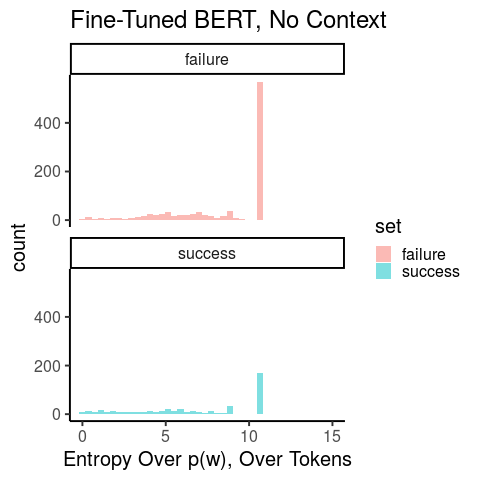

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



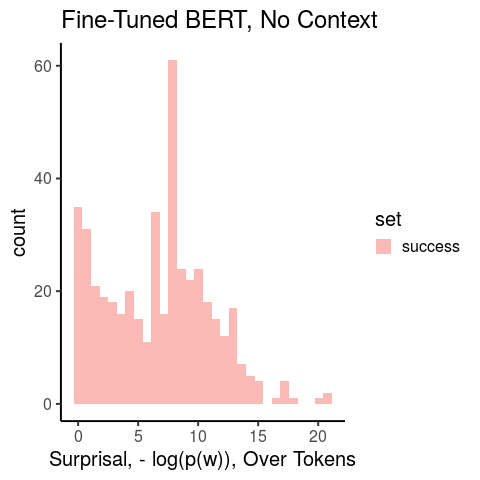

[1] 6.645816


R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



In [2304]:
plot_entropies(ft1_no_context,'Fine-Tuned BERT, No Context','ftb_nocontext')

In [2714]:
adult_no_context = transfomers_bert_completions.compare_successes_failures(all_tokens_phono,
    selected_success_utts, selected_yyy_utts, adult_bertMaskedLM, adult_tokenizer,
    adult_softmax_mask, None, use_speaker_labels=False)

Computing failure scores
Computing success scores


/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



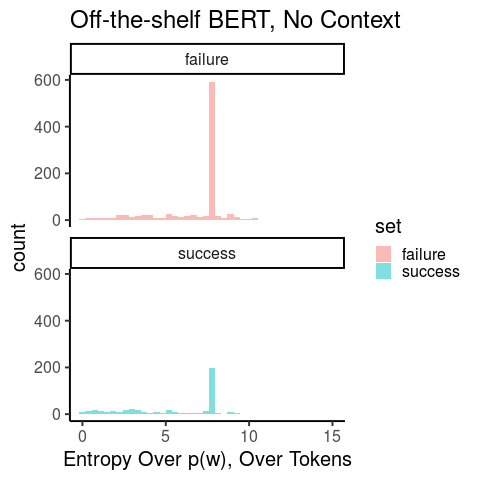

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



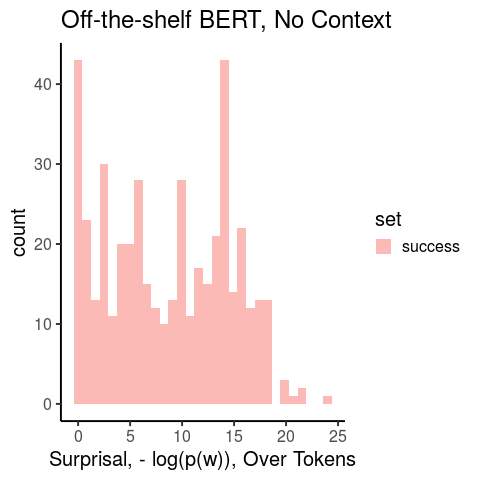

[1] 8.656242


R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



In [2308]:
plot_entropies(adult_no_context,'Off-the-shelf BERT, No Context','otsb_nocontext')

In [2309]:
ft2_no_context = transfomers_bert_completions.compare_successes_failures(all_tokens_phono,
    selected_success_utts, selected_yyy_utts, ft2_bertMaskedLM, ft2_tokenizer,
    ft2_softmax_mask,  None, use_speaker_labels=False)

Computing failure scores
Computing success scores


/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



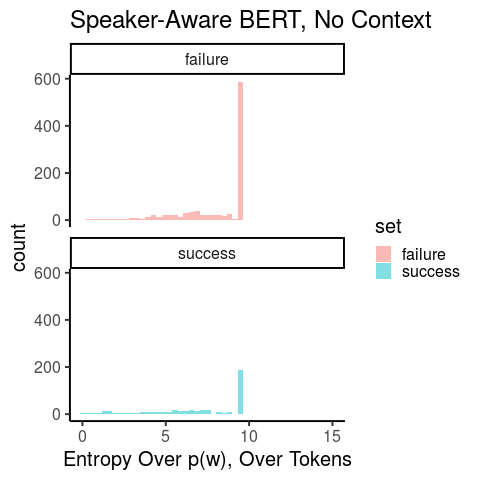

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



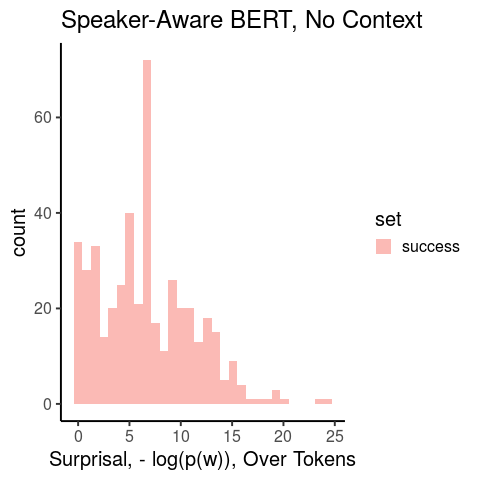

[1] 6.597594


R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



In [2310]:
plot_entropies(ft2_no_context,'Speaker-Aware BERT, No Context',
               'ftb2_nocontext')

Need to look more into the tokenization for the Speaker-aware model

In [2311]:
adult_5context = transfomers_bert_completions.compare_successes_failures(all_tokens_phono,
    selected_success_utts, selected_yyy_utts, adult_bertMaskedLM, adult_tokenizer,
    adult_softmax_mask, 5, use_speaker_labels=False)

Computing failure scores
Computing success scores


/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



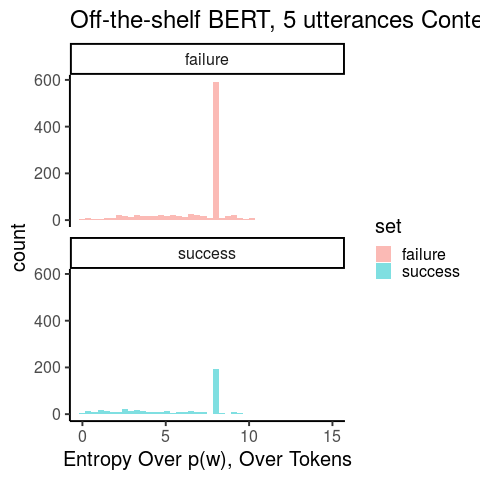

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



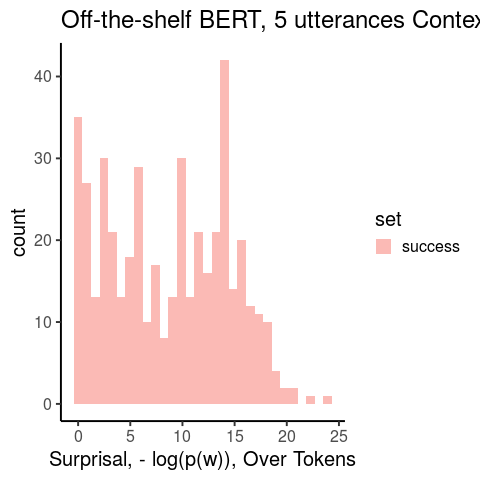

[1] 8.583074


R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



In [2312]:
plot_entropies(adult_5context,'Off-the-shelf BERT, 5 utterances Context',
               'otsb_5uttscontext')

In [2313]:
ft1_5context = transfomers_bert_completions.compare_successes_failures(all_tokens_phono,
    selected_success_utts, selected_yyy_utts, ft1_bertMaskedLM, ft1_tokenizer,
    ft1_softmax_mask,  5, use_speaker_labels=False)

Computing failure scores
Computing success scores


/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



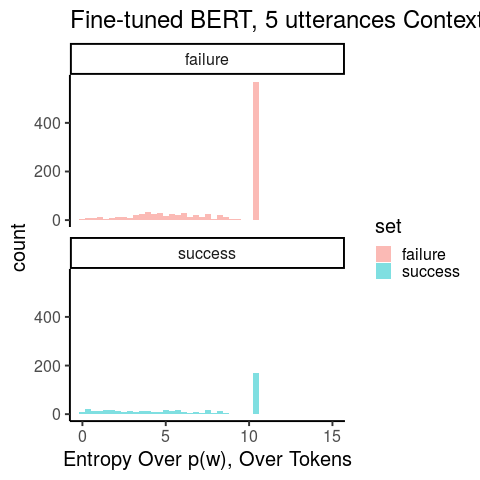

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



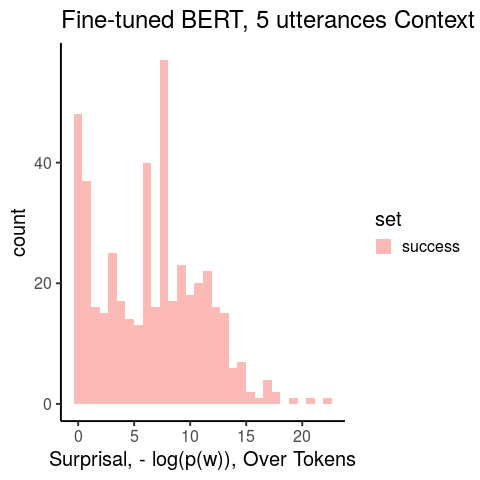

[1] 6.534128


R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



In [2314]:
plot_entropies(ft1_5context,'Fine-tuned BERT, 5 utterances Context',
               'ft1_5uttscontext')

In [2631]:
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)
ft1_20context = transfomers_bert_completions.compare_successes_failures(all_tokens_phono,
    selected_success_utts, selected_yyy_utts, ft1_bertMaskedLM, ft1_tokenizer,
    ft1_softmax_mask, 20, use_speaker_labels=False)

Computing failure scores
Computing success scores


R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



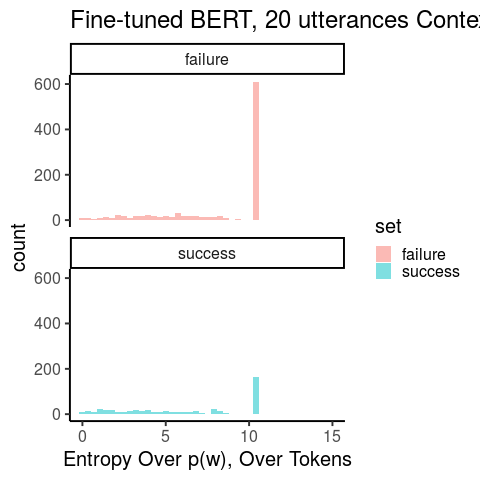

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



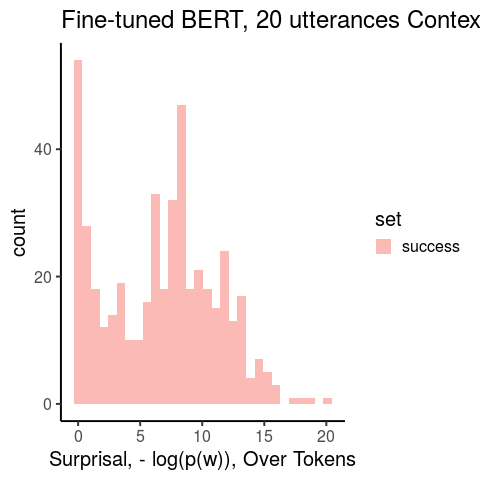

[1] 6.662163


R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



In [2713]:
plot_entropies(ft1_20context,'Fine-tuned BERT, 20 utterances Context',
               'ft1_20uttscontext')

In [2632]:
adult_20context = transfomers_bert_completions.compare_successes_failures(all_tokens_phono,
    selected_success_utts, selected_yyy_utts, adult_bertMaskedLM, adult_tokenizer,
    adult_softmax_mask, 20, use_speaker_labels=False)

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Computing failure scores
Computing success scores


### Unigram Model

In [2677]:
unigram_scores = transfomers_bert_completions.compare_successes_failures_unigram_model(
    all_tokens_phono,
    selected_success_utts,
    selected_yyy_utts,
    adult_tokenizer,
    adult_softmax_mask,
    'data/chi_vocab.csv',
    initial_vocab)

In [2678]:
unigram_scores['scores']

,token,bert_token_id,entropy,set,word,Unnamed: 0,count,prob
940,yyy,940,5.862046,failure,NaN,NaN,NaN,NaN
5157,yyy,5157,5.862046,failure,NaN,NaN,NaN,NaN
5802,yyy,5802,5.862046,failure,NaN,NaN,NaN,NaN
7418,yyy,7418,5.862046,failure,NaN,NaN,NaN,NaN
7717,yyy,7717,5.862046,failure,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1968,from,3083127,5.862046,success,from,210.0,2835.01,0.000703
1969,side,3083128,5.862046,success,side,477.0,1143.01,0.000283
1970,to,3083129,5.862046,success,to,19.0,39724.01,0.009850
1971,side,3083130,5.862046,success,side,477.0,1143.01,0.000283


In [2676]:
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)
unigram_scores_flat = transfomers_bert_completions.compare_successes_failures_unigram_model(
    all_tokens_phono,
    selected_success_utts,
    selected_yyy_utts,
    adult_tokenizer,
    adult_softmax_mask,
    None,
    initial_vocab)

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



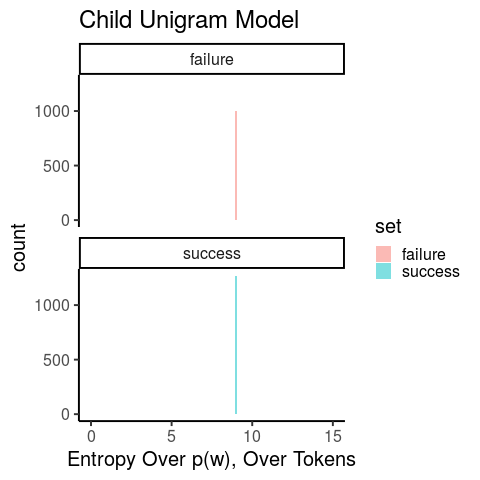

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



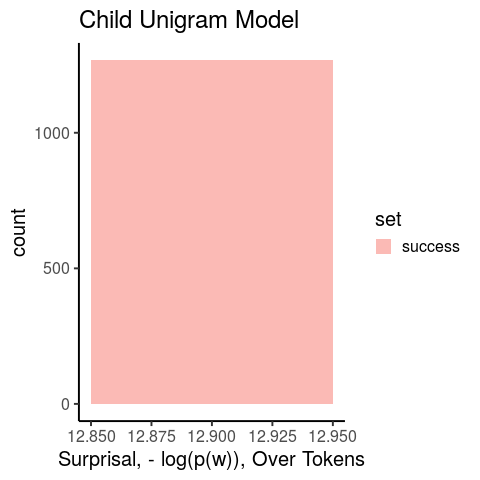

[1] 12.94837


R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



In [2670]:
plot_entropies(unigram_scores_flat,'Child Unigram Model',
               'unigram')

# Likelihood

In [2327]:
cmu_in_childes

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,index,word,pronunciation,phones,ipa,ipa_short,structure,num_vowels
0,71,a,AH0,['AH'],['ə'],ə,['v'],1
1,78,aa,EY2 EY1,"['EY', 'EY']","['eɪ', 'eɪ']",eəeə,"['v', 'v']",2
2,83,aah,AA1,['AA'],['ɑ'],ɑ,['v'],1
3,90,aardvark,AA1 R D V AA2 R K,"['AA', 'R', 'D', 'V', 'AA', 'R', 'K']","['ɑ', 'ɹ', 'd', 'v', 'ɑ', 'ɹ', 'k']",ɑɹdvɑɹk,"['v', 'c', 'c', 'c', 'v', 'c', 'c']",2
4,91,aardvarks,AA1 R D V AA2 R K S,"['AA', 'R', 'D', 'V', 'AA', 'R', 'K', 'S']","['ɑ', 'ɹ', 'd', 'v', 'ɑ', 'ɹ', 'k', 's']",ɑɹdvɑɹks,"['v', 'c', 'c', 'c', 'v', 'c', 'c', 'c']",2
...,...,...,...,...,...,...,...,...
12552,133687,zooms,Z UW1 M Z,"['Z', 'UW', 'M', 'Z']","['z', 'u', 'm', 'z']",zumz,"['c', 'v', 'c', 'c']",1
12553,133688,zoos,Z UW1 Z,"['Z', 'UW', 'Z']","['z', 'u', 'z']",zuz,"['c', 'v', 'c']",1
12554,133703,zorro,Z AO1 R OW2,"['Z', 'AO', 'R', 'OW']","['z', 'ɔ', 'ɹ', 'oʊ']",zɑɹoʊ,"['c', 'v', 'c', 'v']",2
12555,133756,zug,Z AH1 G,"['Z', 'AH', 'G']","['z', 'ə', 'ɡ']",zəɡ,"['c', 'v', 'c']",1


In [2330]:
all_tokens_phono.iloc[0]

token                                                  [cgv]
id                                                  16759250
gloss                             where do you want me to go
transcript_id                                          42204
utterance_order                                            1
speaker_code                                             OPE
type                                                question
punct                                                      ?
speaker_code_simple                                    [CGV]
gloss_with_punct           [CGV] where do you want me to go?
token_id                                               30523
seq_utt_id                                                 0
actual_phonology                                            
model_phonology                                             
target_child_age                                         NaN
bert_token_id                                              0
model_phonology_clean   

In [2882]:
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)

    
levdists = transfomers_bert_completions.get_edit_distance_matrix(all_tokens_phono, ft1_20context, cmu_in_initial_vocab)    
print(levdists)


/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[3 4 3 ... 3 3 4]
 [5 5 6 ... 5 5 5]
 [0 3 3 ... 2 3 4]
 ...
 [1 3 3 ... 2 2 4]
 [0 3 3 ... 2 3 4]
 [2 3 3 ... 3 3 4]]


In [2883]:
levdists.shape

(1470, 7904)

In [2415]:
ft1_20context['priors']

array([[5.8380407e-03, 1.7672523e-04, 1.2154242e-04, ..., 4.6883823e-08,
        1.1294791e-06, 1.2715525e-07],
       [1.2080671e-03, 1.9414749e-05, 6.7555484e-05, ..., 1.5851953e-08,
        1.0938782e-06, 4.1567856e-09],
       [1.6402908e-02, 3.6393015e-03, 2.8670379e-03, ..., 1.8431924e-06,
        1.5677216e-04, 1.0482791e-05],
       ...,
       [1.6402908e-02, 3.6393015e-03, 2.8670379e-03, ..., 1.8431924e-06,
        1.5677216e-04, 1.0482791e-05],
       [2.3590240e-03, 7.9396224e-05, 2.9158364e-05, ..., 8.5628971e-09,
        1.0797735e-07, 2.6887534e-08],
       [1.3285609e-02, 1.7654407e-04, 4.3717504e-04, ..., 8.5339300e-09,
        4.7167822e-07, 5.5385789e-09]], dtype=float32)

In [2439]:
ft1_20context['scores'].loc[ft1_20context['scores'].set == 'success']

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,rank,prob,entropy,num_tokens_in_context,bert_token_id,set,mask_position,token,utterance_id,posterior_entropy
226868,77.0,0.000969,5.216011,6,226868.0,success,0.0,mommy,16800234.0,2.650011
2994758,1206.0,0.000133,10.400938,3,2994758.0,success,0.0,roar,17210787.0,6.716292
1622789,19.0,0.004511,10.400938,3,1622789.0,success,0.0,yes,17010045.0,6.756852
1627232,7198.0,0.000005,10.400938,3,1627232.0,success,0.0,shelly,17010681.0,6.860906
1143941,1242.0,0.000129,10.400938,3,1143941.0,success,0.0,woo,16944435.0,6.314640
...,...,...,...,...,...,...,...,...,...,...
1514153,5.0,0.008688,2.184600,4,1514153.0,success,0.0,look,16994211.0,1.860061
2352913,105.0,0.001351,10.400938,3,2352913.0,success,0.0,baby,17107713.0,6.700647
1293566,820.0,0.000206,10.400938,3,1293566.0,success,0.0,lovely,16964067.0,6.647795
2134161,0.0,0.721052,2.230507,7,2134161.0,success,0.0,what,17078606.0,0.587448


In [2440]:
ft1_20context['scores'].loc[ft1_20context['scores'].set == 'failure']

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,rank,prob,entropy,num_tokens_in_context,bert_token_id,set,mask_position,token,utterance_id,posterior_entropy
1509259,NaN,NaN,3.569862,5,1509259.0,failure,NaN,NaN,NaN,2.110420
307478,NaN,NaN,5.133621,6,307478.0,failure,NaN,NaN,NaN,3.949710
1421579,NaN,NaN,10.400938,3,1421579.0,failure,NaN,NaN,NaN,6.810222
258713,NaN,NaN,10.400938,3,258713.0,failure,NaN,NaN,NaN,6.550589
1149072,NaN,NaN,6.178402,4,1149072.0,failure,NaN,NaN,NaN,1.668274
...,...,...,...,...,...,...,...,...,...,...
1240281,NaN,NaN,9.325622,4,1240281.0,failure,NaN,NaN,NaN,5.543711
829062,NaN,NaN,10.400938,3,829062.0,failure,NaN,NaN,NaN,5.661822
2171271,NaN,NaN,3.781035,7,2171271.0,failure,NaN,NaN,NaN,3.011072
1177846,NaN,NaN,10.400938,3,1177846.0,failure,NaN,NaN,NaN,5.640816


In [2642]:
ft1_20context_posteriors = get_posteriors(ft1_20context, levdists, initial_vocab)

In [2643]:
ft1_20context_posteriors['scores'].shape

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1470, 14)

In [ ]:
#edge case: if the child production is 2 syllable but the target is 3 syllables,
# then the "success" token isn't in the vocbulary

In [2523]:
def posterior_entropy(data, title, filename):    
   # handle the hierarchical reutrn object     
    df1 = data['scores'][['posterior_entropy','set','edit_distance','posterior_surprisal']]
    %R -i df1,title,filename
    %R p1 = ggplot(df1) + geom_histogram(aes(x=posterior_entropy,  fill=set), alpha =.5 \
        ) + theme_classic(base_size=20) + facet_wrap(~set, ncol=1 \
        ) + coord_cartesian(xlim=c(0,10)) 
    %R p1 = p1 + ggtitle(title) + xlab('Posterior Entropy Over p(w), Over Tokens')
    %R print(p1)
    %R ggsave(paste0('figures/', filename,'_entropy.pdf'), width= 8, height=4)      
    
    # p(success) by entropy)
    %R successes = subset(df1, set == 'success') 
    %R failures = subset(df1, set == 'failure') 
    %R categ_min = min(nrow(successes), nrow(failures))
    %R sampled_successes = successes[sample(1:nrow(successes),categ_min, replace=F),]
    %R sampled_failures = failures[sample(1:nrow(failures),categ_min, replace=F),]
    %R sampled = rbind(sampled_successes, sampled_failures)
    %R sampled$posterior_entropy_bin = floor(sampled$posterior_entropy)
    %R prop_success = aggregate(set ~ posterior_entropy_bin, sampled, function(x){mean(x == 'success')})
    %R print(ggplot(prop_success) + geom_line(aes(x=posterior_entropy_bin, y=set) \
        ) + xlab('Posterior Entropy Over Candidate Word Identities (bits)') + ylab('Probability of Communicative Success' \
        ) +theme_classic(base_size=20) + geom_point(aes(x=posterior_entropy_bin, y=set)))
    
    

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



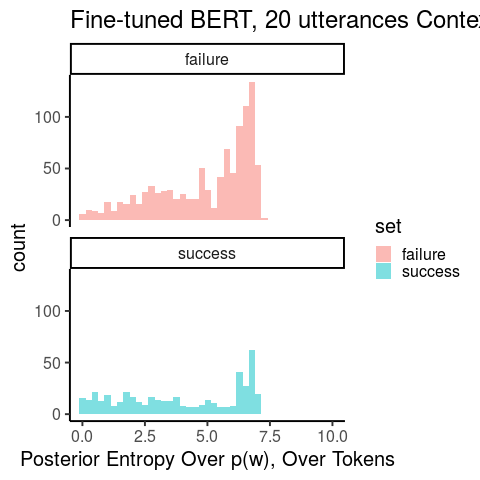

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



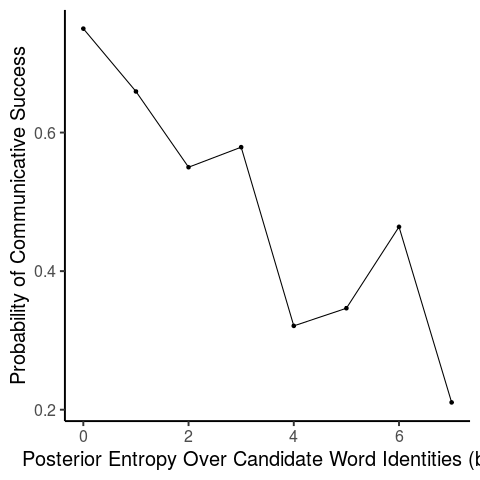

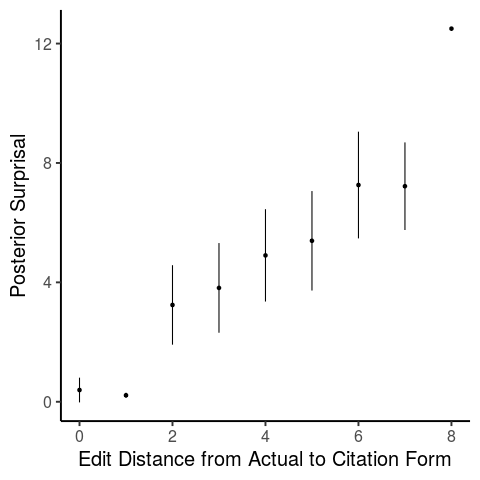

In [2524]:
posterior_entropy(ft1_20context_posteriors, 'Fine-tuned BERT, 20 utterances Context',
               'ft1_20uttscontext_posteriorEntropy')

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



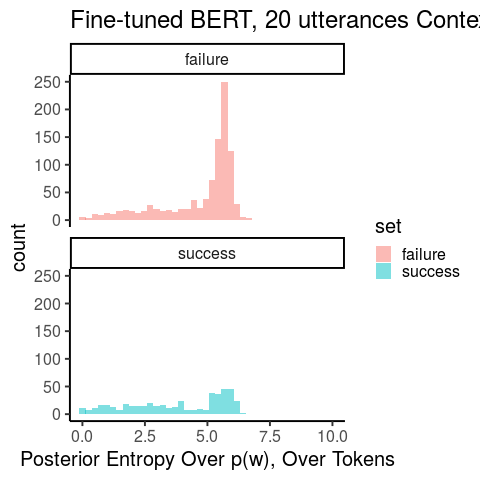

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



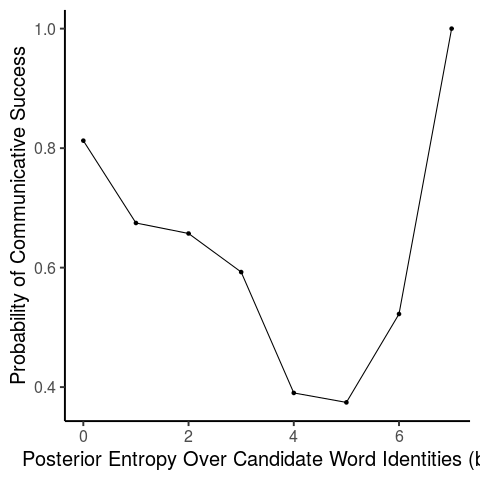

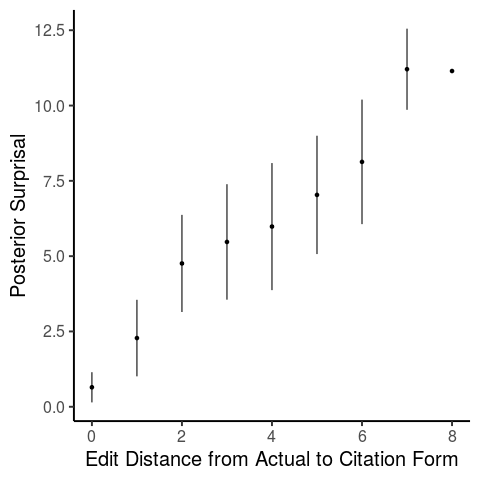

In [2644]:
adult_20context_posteriors = get_posteriors(adult_20context, levdists, initial_vocab)
posterior_entropy(adult_20context_posteriors, 'Fine-tuned BERT, 20 utterances Context',
               'adult_20uttscontext_posteriorEntropy')

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2833]:
unigram_posteriors = get_posteriors(unigram_scores, levdists, initial_vocab, 
    adult_20context_posteriors['scores']['bert_token_id'])
flat_posteriors = get_posteriors(unigram_scores_flat, levdists, initial_vocab, 
    adult_20context_posteriors['scores']['bert_token_id'])


In [2834]:
ft1_no_context_posteriors = get_posteriors(ft1_no_context, levdists, initial_vocab)
adult_no_context_posteriors = get_posteriors(adult_no_context, levdists, initial_vocab)

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2835]:
ft1_no_context_posteriors['scores'].prior_suprisal

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1875213         NaN
1746247         NaN
900455          NaN
1154064         NaN
544694          NaN
             ...   
2647237         NaN
479660     0.012233
1377892    0.216988
2808225    0.767019
1471640    0.672950
Name: prior_suprisal, Length: 1470, dtype: float64

In [2718]:
adult_20context_posteriors['scores']['model'] = 'Adult BERT, 40 utts context'
ft1_20context_posteriors['scores']['model'] = 'CHILDES BERT, 40 utts context'
unigram_posteriors['scores']['model'] = 'CHILDES unigram'
flat_posteriors['scores']['model'] = 'flat'
ft1_no_context_posteriors['scores']['model'] = 'CHILDES BERT, no context'
adult_no_context_posteriors['scores']['model'] = 'Adult BERT, no context'

scores = pd.concat([adult_20context_posteriors['scores'], ft1_20context_posteriors['scores'],
    unigram_posteriors['scores'], flat_posteriors['scores'], ft1_no_context_posteriors['scores'],
adult_no_context_posteriors['scores']])

In [2722]:
scores.model.value_counts()

Adult BERT, no context           1470
CHILDES unigram                  1470
Adult BERT, 40 utts context      1470
flat                             1470
CHILDES BERT, 40 utts context    1470
CHILDES BERT, no context         1470
Name: model, dtype: int64

In [2956]:
# probability of success by edit distance
def posterior_by_edit_distance_plot(data, title, filename):   
    df1 = data[['posterior_entropy','set','edit_distance','posterior_surprisal','model']]

    %R successes = subset(df1, set == 'success') 
    %R -i df1,title,filename
    %R surprisal_by_edit_distance = aggregate(posterior_surprisal ~ edit_distance + model, successes, \
        function(x){mean(-1 * log(x))})
    %R names(surprisal_by_edit_distance) = c('edit_distance', 'model', 'mean_posterior_surprisal')
    %R sem <- function(x) sd(x)/sqrt(length(x))
    %R surprisal_by_edit_distance_sem = aggregate(posterior_surprisal ~ edit_distance + model, successes, \
        function(x){sem(-1 * log(x))})
    %R names(surprisal_by_edit_distance_sem) = c('edit_distance','model','mean_posterior_surprisal_sem')
    %R surprisal_by_edit_distance = merge(surprisal_by_edit_distance, surprisal_by_edit_distance_sem)
    %R surprisal_by_edit_distance$high = surprisal_by_edit_distance$mean_posterior_surprisal \
        + 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
    %R surprisal_by_edit_distance$low = surprisal_by_edit_distance$mean_posterior_surprisal \
        - 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
    %R test = subset(surprisal_by_edit_distance, edit_distance ==1 )
    %R test$prob = exp(-1*test$mean_posterior_surprisal)
    %R print(test)
    %R p1= ggplot(surprisal_by_edit_distance) + geom_point(aes(x=edit_distance, \
        y = mean_posterior_surprisal, color = model, shape=model), size=5) + theme_classic(base_size=24) + xlab( \
        'Edit Distance from Actual to Citation Form') + ylab('Posterior Surprisal') + \
        geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model), width = 0)
    %R -h 800 -w 1600 print(p1) 

   edit_distance                         model mean_posterior_surprisal
7              1   Adult BERT, 40 utts context                 2.280209
8              1        Adult BERT, no context                 2.387881
9              1 CHILDES BERT, 40 utts context                 1.357173
10             1      CHILDES BERT, no context                 1.109219
11             1               CHILDES unigram                 1.373651
12             1                          flat                 6.389614
   mean_posterior_surprisal_sem     high       low        prob
7                    1.03798924 2.799204 1.7612145 0.102262817
8                    1.14161032 2.958687 1.8170762 0.091824017
9                    0.85922196 1.786784 0.9275624 0.257387277
10                   0.58802426 1.403231 0.8152065 0.329816561
11                   0.13109659 1.439199 1.3081024 0.253180996
12                   0.01719609 6.398212 6.3810162 0.001678904


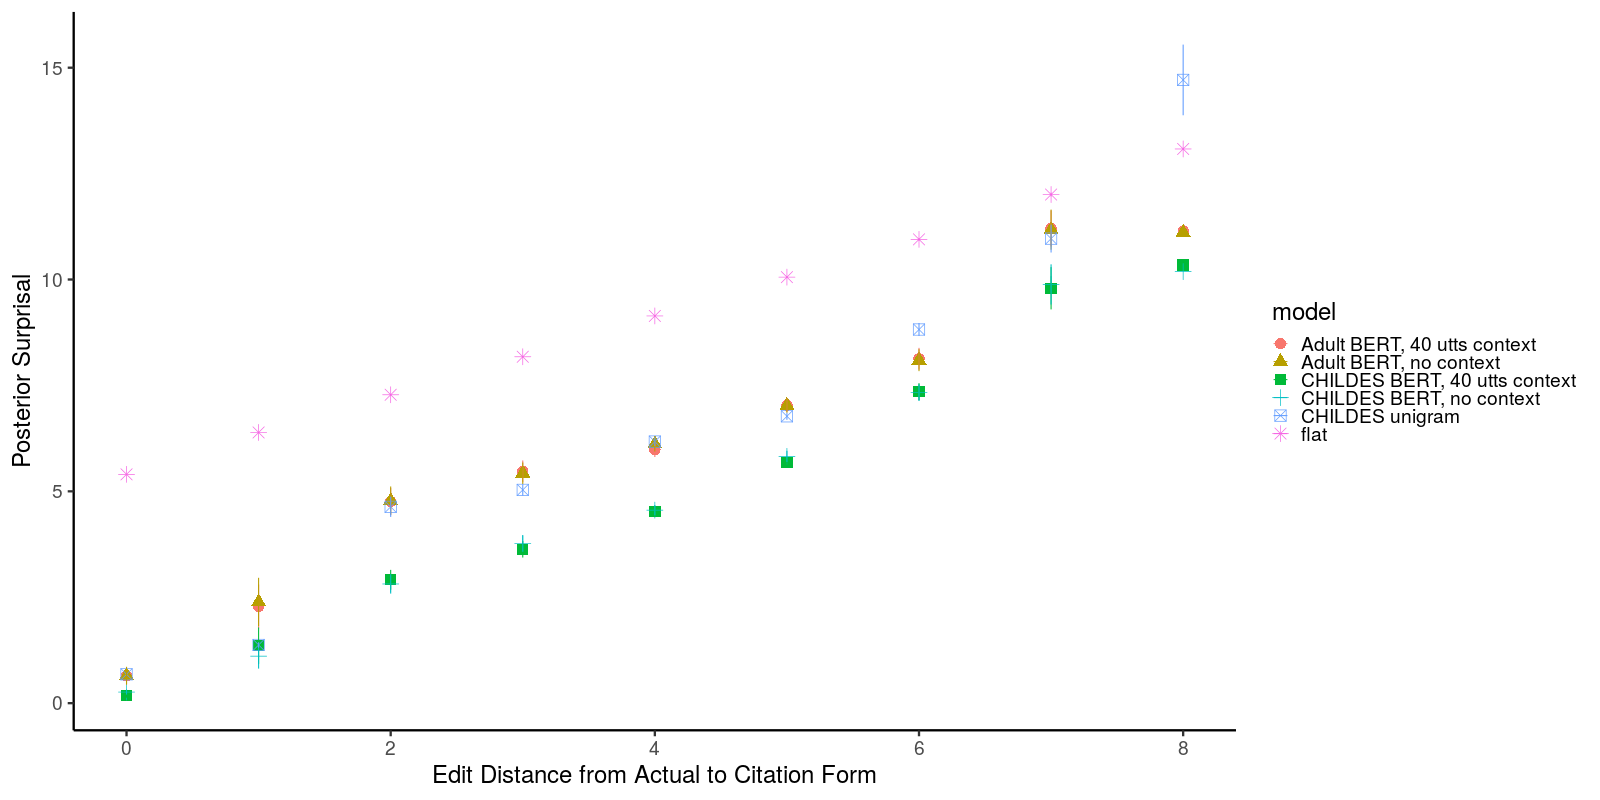

In [2957]:
posterior_by_edit_distance_plot(scores, '', 'posterior_by_editdistance_comparison')

### Prior probability of utterances across time

In [2729]:
# get number of tokens per age
success_utts['set'] = 'success'
yyy_utts['set'] = 'failure'



/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# get child age in days associated with each utterance id and plot it

In [2728]:
utt_age = pvd_chi_tokens.groupby('utterance_id').target_child_age.agg(np.unique).reset_index()

In [2732]:
utts_with_ages = pd.concat([success_utts, yyy_utts]).merge(utt_age)
%R -i utts_with_ages

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


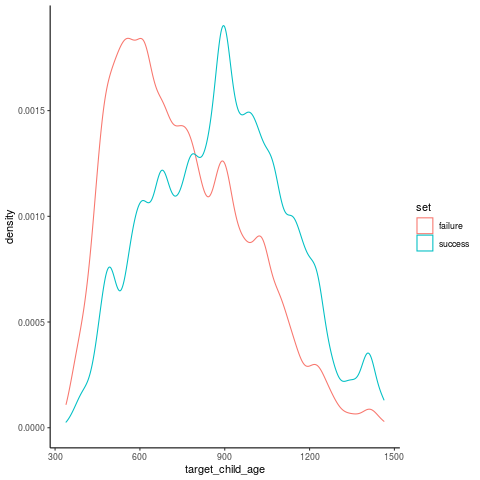

In [2733]:
%%R
ggplot(utts_with_ages) + geom_density(aes(x=target_child_age, color=set)) + theme_classic()

In [2740]:
utts_with_ages['year'] = .5*np.floor(utts_with_ages['target_child_age'] / (365. /2) ) 

In [2743]:
utts_with_ages.loc[utts_with_ages.set == 'failure'].year.value_counts()

1.5    9919
2.0    7261
1.0    6693
2.5    4895
3.0    2097
3.5     414
0.5     167
4.0      11
Name: year, dtype: int64

In [2741]:
utts_with_ages.loc[utts_with_ages.set == 'success'].year.value_counts()

2.0    22432
2.5    21194
1.5    16798
3.0    12564
1.0     6697
3.5     3683
4.0      379
0.5      133
Name: year, dtype: int64

In [ ]:
# Draw without replacement if over 1000

In [2749]:
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)

<module 'transfomers_bert_completions' from '/home/stephan/notebooks/child-directed-listening/transfomers_bert_completions.py'>

In [3005]:
models = [
{'title': 'CHILDES BERT, 40 utts context',
 'kwargs': {'modelLM': ft1_bertMaskedLM,
            'tokenizer': ft1_tokenizer,
            'softmax_mask': ft1_softmax_mask,
            'num_context_utts': 20,
            'use_speaker_labels':False
           },
 'type': 'BERT'
},
{'title': 'Adult BERT, 40 utts context',
'kwargs': {'modelLM': adult_bertMaskedLM,
            'tokenizer': adult_tokenizer,
            'softmax_mask': adult_softmax_mask,
            'num_context_utts': 20,
           'use_speaker_labels':False
           },
 'type': 'BERT'
},
{'title': 'CHILDES Unigram',
'kwargs': {'child_counts_path': 'data/chi_vocab.csv',
            'tokenizer': adult_tokenizer,
            'softmax_mask': adult_softmax_mask,
            'vocab': initial_vocab
           },
 'type': 'unigram'
},
{'title': 'Flat Unigram',
'kwargs': {'child_counts_path': None,
            'tokenizer': adult_tokenizer,
            'softmax_mask': adult_softmax_mask,
            'vocab': initial_vocab
           },
 'type': 'unigram'
}]



In [3010]:
# Sample one model across time
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<module 'transfomers_bert_completions' from '/home/stephan/notebooks/child-directed-listening/transfomers_bert_completions.py'>

In [3011]:
scores_across_time = transfomers_bert_completions.sample_models_across_time(utts_with_ages, 
    all_tokens_phono, models, initial_vocab, cmu_in_initial_vocab)

Running models for age 0.5
Running model CHILDES BERT, 40 utts context...
Computing failure scores
Computing success scores
Running model Adult BERT, 40 utts context...
Computing failure scores
Computing success scores
Running model CHILDES Unigram...
Running model Flat Unigram...
Running models for age 1.0
Running model CHILDES BERT, 40 utts context...
Computing failure scores
Computing success scores
Running model Adult BERT, 40 utts context...
Computing failure scores
Computing success scores
Running model CHILDES Unigram...
Running model Flat Unigram...
Running models for age 1.5
Running model CHILDES BERT, 40 utts context...
Computing failure scores
Computing success scores
Running model Adult BERT, 40 utts context...
Computing failure scores
Computing success scores
Running model CHILDES Unigram...
Running model Flat Unigram...
Running models for age 2.0
Running model CHILDES BERT, 40 utts context...
Computing failure scores
Computing success scores
Running model Adult BERT, 40 u

In [3012]:
scores_across_time.shape

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(88872, 23)

In [3013]:
scores_across_time.model.value_counts()

CHILDES BERT, 40 utts context    22218
Adult BERT, 40 utts context      22218
Flat Unigram                     22218
CHILDES Unigram                  22218
Name: model, dtype: int64

In [3014]:
successes_across_time = scores_across_time.loc[scores_across_time.set == 
    'success'][['posterior_surprisal','posterior_entropy','prior_surprisal','kl_flat_to_prior',
                'kl_flat_to_posterior', 'model','set','age']]
%R -i successes_across_time
%R mean_surprisal_by_age = aggregate(posterior_surprisal ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x))})
%R names(mean_surprisal_by_age) = c('age','model','posterior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(posterior_surprisal ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x))})
%R names(mean_surprisal_by_age_sem) = c('age','model','posterior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 
%R print(mean_surprisal_by_age)

   age                         model posterior_surprisal_mean
1  0.5   Adult BERT, 40 utts context                 9.134589
2  0.5 CHILDES BERT, 40 utts context                 5.909594
3  0.5               CHILDES Unigram                 6.739613
4  0.5                  Flat Unigram                 9.021368
5  1.5   Adult BERT, 40 utts context                 7.467324
6  1.5 CHILDES BERT, 40 utts context                 5.782466
7  1.5               CHILDES Unigram                 6.913598
8  1.5                  Flat Unigram                 9.403350
9  1.0   Adult BERT, 40 utts context                 9.397105
10 1.0 CHILDES BERT, 40 utts context                 6.949322
11 1.0               CHILDES Unigram                 8.005808
12 1.0                  Flat Unigram                 9.435297
13 2.5   Adult BERT, 40 utts context                 5.720314
14 2.5 CHILDES BERT, 40 utts context                 4.525442
15 2.5               CHILDES Unigram                 6.040337
16 2.5  

,age,model,posterior_surprisal_mean,posterior_surprisal_sem
1,0.5,"Adult BERT, 40 utts context",9.134589,0.422708
2,0.5,"CHILDES BERT, 40 utts context",5.909594,0.328312
3,0.5,CHILDES Unigram,6.739613,0.221606
4,0.5,Flat Unigram,9.021368,0.098195
5,1.5,"Adult BERT, 40 utts context",7.467324,0.094417
6,1.5,"CHILDES BERT, 40 utts context",5.782466,0.080344
7,1.5,CHILDES Unigram,6.913598,0.066653
8,1.5,Flat Unigram,9.403350,0.031583
9,1.0,"Adult BERT, 40 utts context",9.397105,0.082921
10,1.0,"CHILDES BERT, 40 utts context",6.949322,0.083784


/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


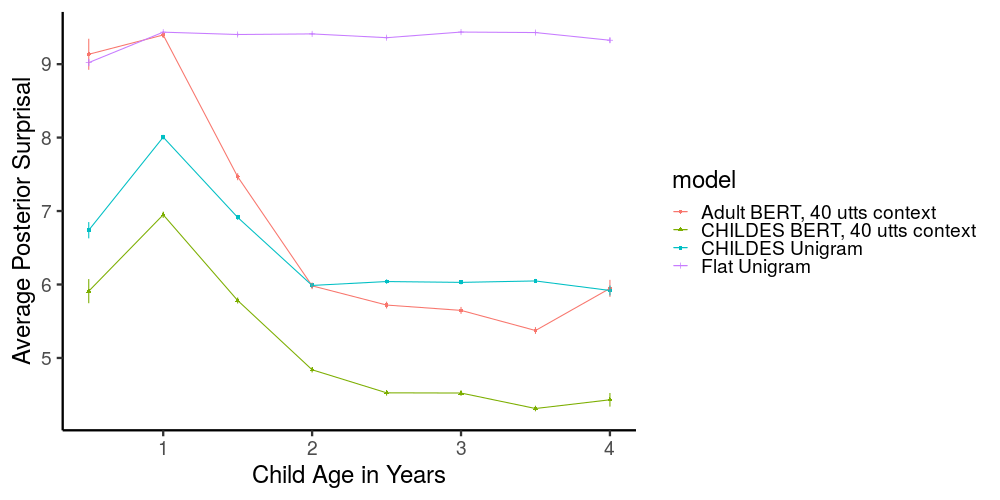

In [3015]:
%%R -w 1000 -h 500
ggplot(mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years')

In [3016]:
## scores_across_time = pd.concat(score_store)
%R mean_surprisal_by_age = aggregate(prior_surprisal ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x))})
%R names(mean_surprisal_by_age) = c('age','model','prior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(prior_surprisal ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x))})
%R names(mean_surprisal_by_age_sem) = c('age','model','prior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 

,age,model,prior_surprisal_mean,prior_surprisal_sem
1,0.5,"Adult BERT, 40 utts context",9.208837,0.401056
2,0.5,"CHILDES BERT, 40 utts context",5.738103,0.288560
3,0.5,CHILDES Unigram,6.496397,0.144806
4,0.5,Flat Unigram,8.975124,0.000000
5,1.5,"Adult BERT, 40 utts context",7.105891,0.088640
6,1.5,"CHILDES BERT, 40 utts context",5.256994,0.073049
7,1.5,CHILDES Unigram,6.322801,0.056871
8,1.5,Flat Unigram,8.975124,0.000000
9,1.0,"Adult BERT, 40 utts context",9.000072,0.072684
10,1.0,"CHILDES BERT, 40 utts context",6.406895,0.073068


/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


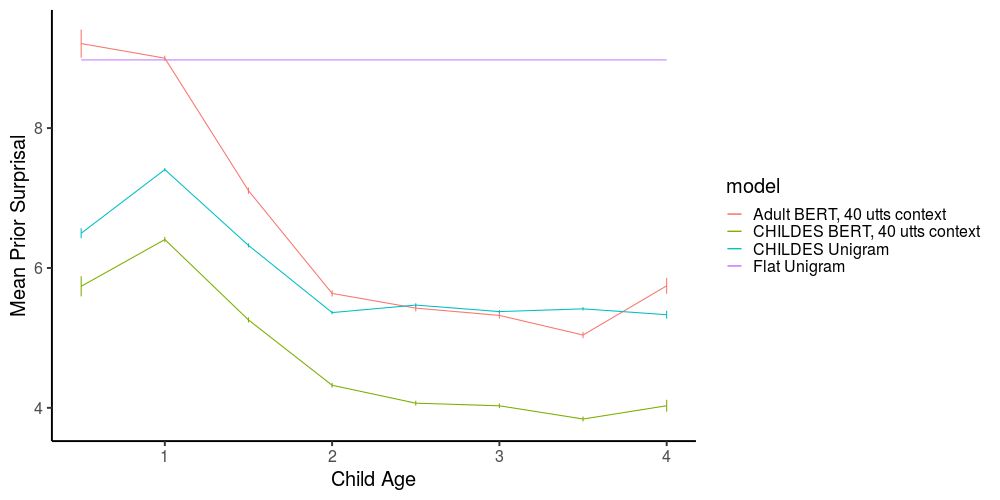

In [3017]:
%%R -w 1000 -h 500
ggplot(mean_surprisal_by_age) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model)
) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
ymax=prior_surprisal_mean + .5*prior_surprisal_sem , color=model), width=0) + theme_classic(
base_size=20) + ylab('Mean Prior Surprisal') + xlab('Child Age')

In [3018]:
scores_across_time_short = scores_across_time[['posterior_surprisal','posterior_entropy','prior_surprisal','model','set','age']]
%R -i scores_across_time_short
%R posterior_entropy_by_age = aggregate(posterior_entropy ~ age + model + set, scores_across_time_short ,\
                function(x){mean(x)})
%R names(posterior_entropy_by_age) = c('age','model', 'set', 'posterior_entropy_mean')
%R posterior_entropy_by_age_sem = aggregate(posterior_entropy ~ age + model + set, \
        scores_across_time_short, sem)
%R names(posterior_entropy_by_age_sem) = c('age','model','set','posterior_entropy_sem')
%R posterior_entropy_by_age = merge(posterior_entropy_by_age, posterior_entropy_by_age_sem) 
%R posterior_entropy_by_age

,age,model,set,posterior_entropy_mean,posterior_entropy_sem
1,0.5,"Adult BERT, 40 utts context",failure,5.534421,0.050328
2,0.5,"Adult BERT, 40 utts context",success,4.862212,0.142484
3,0.5,"CHILDES BERT, 40 utts context",failure,6.227379,0.078033
4,0.5,"CHILDES BERT, 40 utts context",success,5.147829,0.199908
5,0.5,CHILDES Unigram,failure,5.053527,0.035786
...,...,...,...,...,...
60,4.0,"CHILDES BERT, 40 utts context",success,3.576492,0.124993
61,4.0,CHILDES Unigram,failure,4.733666,0.153560
62,4.0,CHILDES Unigram,success,4.796506,0.035752
63,4.0,Flat Unigram,failure,8.282913,0.028665


/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


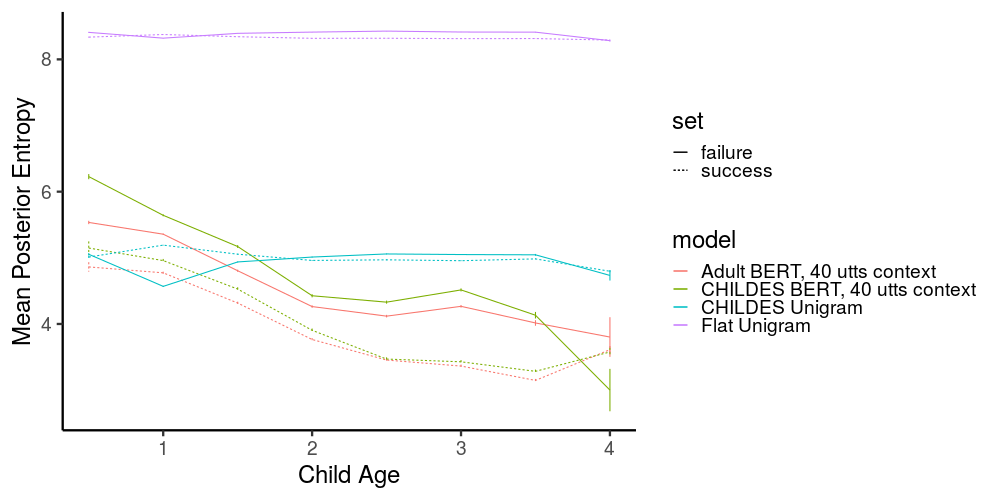

In [3019]:
%%R -w 1000 -h 500
ggplot(posterior_entropy_by_age) + geom_line(aes(x=age, y=posterior_entropy_mean, color=model, linetype=set)
) + geom_errorbar(aes(x=age, ymin=posterior_entropy_mean - .5*posterior_entropy_sem, 
ymax=posterior_entropy_mean + .5*posterior_entropy_sem, color=model, linetype=set ), width=0) + theme_classic(
base_size=24) + ylab('Mean Posterior Entropy') + xlab('Child Age')

In [3020]:
%R mean_kl_flat_to_prior_by_age = aggregate(kl_flat_to_prior ~ age + model, successes_across_time, mean)
%R names(mean_kl_flat_to_prior_by_age) = c('age','model','kl_flat_to_prior')
%R mean_kl_flat_to_prior_by_age_sem = aggregate(kl_flat_to_prior ~ age + model, \
        successes_across_time, sem)
%R names(mean_kl_flat_to_prior_by_age_sem) = c('age','model','kl_flat_to_prior_sem')
%R mean_kl_flat_to_prior_by_age = merge(mean_kl_flat_to_prior_by_age, mean_kl_flat_to_prior_by_age_sem) 
%R print(mean_kl_flat_to_prior_by_age)

   age                         model kl_flat_to_prior kl_flat_to_prior_sem
1  0.5   Adult BERT, 40 utts context         2.806166           0.13748147
2  0.5 CHILDES BERT, 40 utts context         2.903573           0.24192658
3  0.5               CHILDES Unigram         3.812681           0.00000000
4  0.5                  Flat Unigram         0.000000           0.00000000
5  1.5   Adult BERT, 40 utts context         3.409583           0.04803155
6  1.5 CHILDES BERT, 40 utts context         3.823479           0.06378860
7  1.5               CHILDES Unigram         3.812681           0.00000000
8  1.5                  Flat Unigram         0.000000           0.00000000
9  1.0   Adult BERT, 40 utts context         2.837546           0.03141285
10 1.0 CHILDES BERT, 40 utts context         3.269082           0.05772867
11 1.0               CHILDES Unigram         3.812681           0.00000000
12 1.0                  Flat Unigram         0.000000           0.00000000
13 2.5   Adult BERT, 40 u

,age,model,kl_flat_to_prior,kl_flat_to_prior_sem
1,0.5,"Adult BERT, 40 utts context",2.806166,0.137481
2,0.5,"CHILDES BERT, 40 utts context",2.903573,0.241927
3,0.5,CHILDES Unigram,3.812681,0.000000
4,0.5,Flat Unigram,0.000000,0.000000
5,1.5,"Adult BERT, 40 utts context",3.409583,0.048032
6,1.5,"CHILDES BERT, 40 utts context",3.823479,0.063789
7,1.5,CHILDES Unigram,3.812681,0.000000
8,1.5,Flat Unigram,0.000000,0.000000
9,1.0,"Adult BERT, 40 utts context",2.837546,0.031413
10,1.0,"CHILDES BERT, 40 utts context",3.269082,0.057729


/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


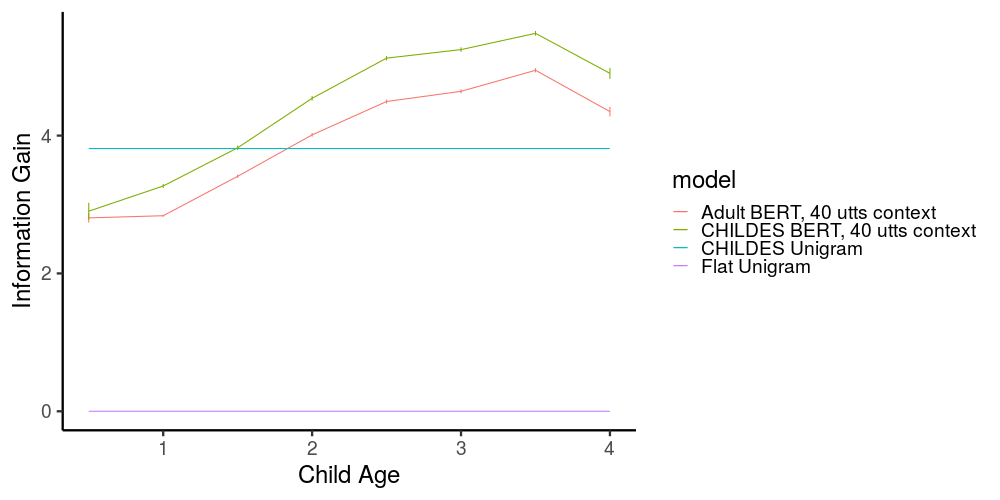

In [3021]:
%%R -w 1000 -h 500
ggplot(mean_kl_flat_to_prior_by_age) + geom_line(aes(x=age, 
y=kl_flat_to_prior, color=model)
) + geom_errorbar(aes(x=age, ymin=kl_flat_to_prior - .5*kl_flat_to_prior_sem, 
ymax=kl_flat_to_prior + .5*kl_flat_to_prior_sem, color=model), width=0) + theme_classic(
base_size=24) + ylab('Information Gain') + xlab('Child Age')

In [3022]:
%R mean_kl_flat_to_posterior_by_age = aggregate(kl_flat_to_posterior ~ age + model, successes_across_time, mean)
%R names(mean_kl_flat_to_posterior_by_age) = c('age','model','kl_flat_to_posterior')
%R mean_kl_flat_to_posterior_by_age_sem = aggregate(kl_flat_to_posterior ~ age + model, \
        successes_across_time, sem)
%R names(mean_kl_flat_to_posterior_by_age_sem) = c('age','model','kl_flat_to_posterior_sem')
%R mean_kl_flat_to_posterior_by_age = merge(mean_kl_flat_to_posterior_by_age, \
    mean_kl_flat_to_posterior_by_age_sem) 
%R print(mean_kl_flat_to_posterior_by_age)

   age                         model kl_flat_to_posterior
1  0.5   Adult BERT, 40 utts context            3.4145556
2  0.5 CHILDES BERT, 40 utts context            3.7577009
3  0.5               CHILDES Unigram            4.7385340
4  0.5                  Flat Unigram            0.7288808
5  1.5   Adult BERT, 40 utts context            4.0674809
6  1.5 CHILDES BERT, 40 utts context            4.6454158
7  1.5               CHILDES Unigram            4.6999413
8  1.5                  Flat Unigram            0.7246896
9  1.0   Adult BERT, 40 utts context            3.4670184
10 1.0 CHILDES BERT, 40 utts context            4.0439488
11 1.0               CHILDES Unigram            4.6439714
12 1.0                  Flat Unigram            0.6926124
13 2.5   Adult BERT, 40 utts context            5.1617195
14 2.5 CHILDES BERT, 40 utts context            5.9552577
15 2.5               CHILDES Unigram            4.7555958
16 2.5                  Flat Unigram            0.7570594
17 2.0   Adult

,age,model,kl_flat_to_posterior,kl_flat_to_posterior_sem
1,0.5,"Adult BERT, 40 utts context",3.414556,0.137489
2,0.5,"CHILDES BERT, 40 utts context",3.757701,0.239231
3,0.5,CHILDES Unigram,4.738534,0.022602
4,0.5,Flat Unigram,0.728881,0.016691
5,1.5,"Adult BERT, 40 utts context",4.067481,0.050385
6,1.5,"CHILDES BERT, 40 utts context",4.645416,0.066808
7,1.5,CHILDES Unigram,4.699941,0.007497
8,1.5,Flat Unigram,0.724690,0.004305
9,1.0,"Adult BERT, 40 utts context",3.467018,0.033359
10,1.0,"CHILDES BERT, 40 utts context",4.043949,0.058086


In [3023]:
%%R
names(mean_kl_flat_to_posterior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_posterior_by_age$comparison = 'posterior'

names(mean_kl_flat_to_prior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_prior_by_age$comparison =  'fitted prior'

kls = rbind(mean_kl_flat_to_posterior_by_age, mean_kl_flat_to_prior_by_age)

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


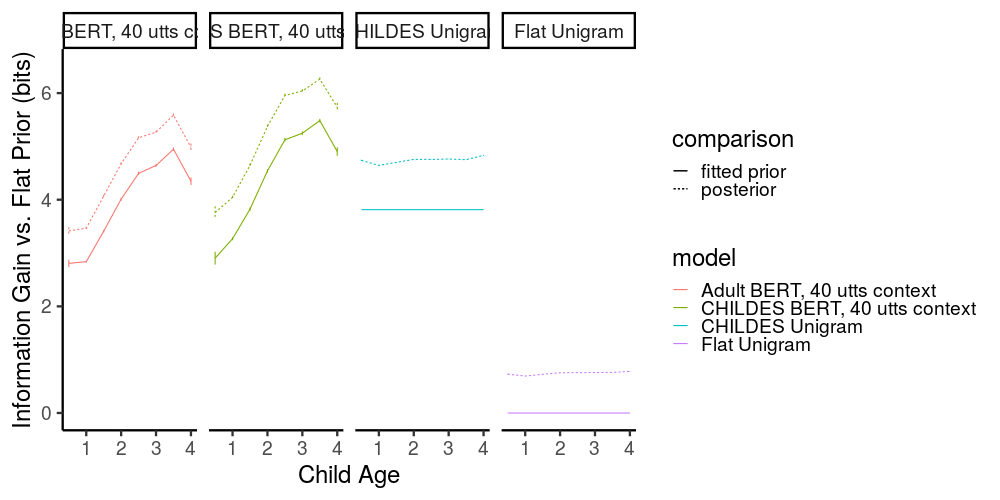

In [3033]:
%%R -w 1000 -h 500
ggplot(kls) + geom_line(aes(x=age, y=gain, color=model, linetype=comparison)
) + geom_errorbar(aes(x=age, ymin=gain - .5*gain_sem, 
ymax=gain + .5*gain_sem, color=model, linetype=comparison), width=0) + theme_classic(
base_size=24) + ylab('Information Gain vs. Flat Prior (bits)') + xlab('Child Age'
) + coord_cartesian(ylim=c(0,6.5)) + facet_wrap(~model, ncol=4)

# check units, add posterior for the flat prior

In [3062]:
%%R
kls_posteriors = subset(kls, comparison == 'posterior')
kls_priors = subset(kls, comparison == 'fitted prior')
kls_priors$prior_gain = kls_priors$gain
kls_posteriors = merge(kls_posteriors,  kls_priors[,c('age','model','prior_gain')],
    on = c('age','model'))
kls_posteriors$gain = kls_posteriors$gain - kls_posteriors$prior_gain
kls_stacked = rbind(kls_priors, kls_posteriors)
kls_stacked


   age                         model      gain    gain_sem   comparison
33 0.5   Adult BERT, 40 utts context 2.8061662 0.137481468 fitted prior
34 0.5 CHILDES BERT, 40 utts context 2.9035725 0.241926583 fitted prior
35 0.5               CHILDES Unigram 3.8126810 0.000000000 fitted prior
36 0.5                  Flat Unigram 0.0000000 0.000000000 fitted prior
37 1.5   Adult BERT, 40 utts context 3.4095835 0.048031549 fitted prior
38 1.5 CHILDES BERT, 40 utts context 3.8234792 0.063788605 fitted prior
39 1.5               CHILDES Unigram 3.8126810 0.000000000 fitted prior
40 1.5                  Flat Unigram 0.0000000 0.000000000 fitted prior
41 1.0   Adult BERT, 40 utts context 2.8375457 0.031412848 fitted prior
42 1.0 CHILDES BERT, 40 utts context 3.2690816 0.057728671 fitted prior
43 1.0               CHILDES Unigram 3.8126810 0.000000000 fitted prior
44 1.0                  Flat Unigram 0.0000000 0.000000000 fitted prior
45 2.5   Adult BERT, 40 utts context 4.4948691 0.057397385 fitte

In [3090]:
%%R
kls_stacked$comparison = factor(kls_stacked$comparison, c('posterior','fitted prior'))
kls$comparison = factor(kls$comparison, c('posterior','fitted prior'))
kls$age_in_months = round(kls$age * 12)
kls_stacked$age_in_months = round(kls$age * 12)

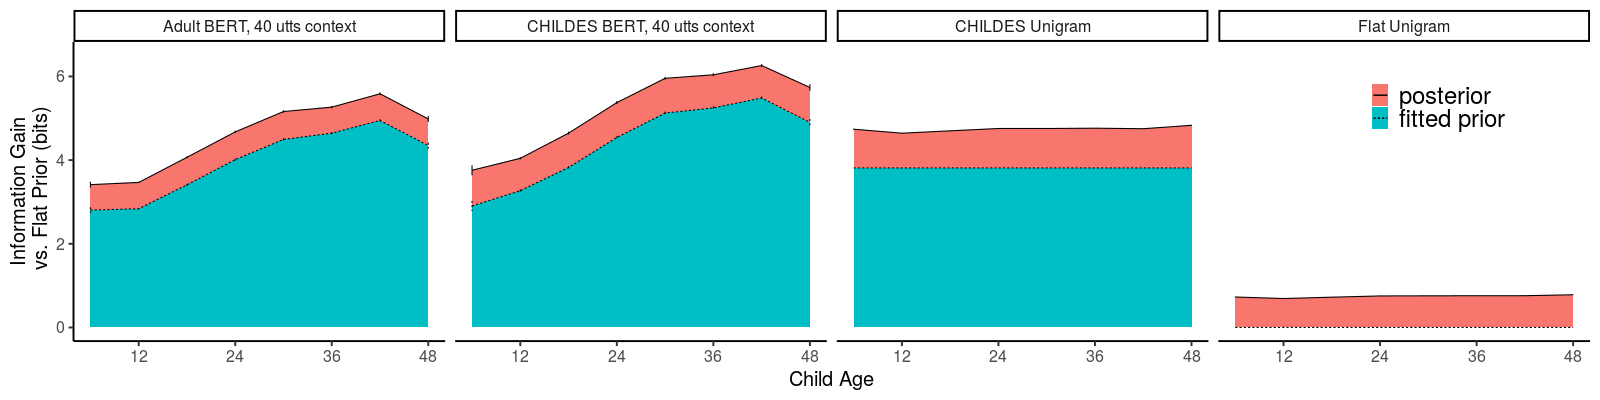

In [3091]:
%%R -w 1600 -h 400
year_intervals_in_months = c(12,24,36,48)
p1 = ggplot(kls_stacked) + geom_area(aes(x=age_in_months, y=gain, fill=comparison) 
) + theme_classic(
base_size=20) + ylab('Information Gain\n vs. Flat Prior (bits)') + xlab('Child Age'
) + coord_cartesian(ylim=c(0,6.5)) + facet_wrap(~model, ncol=4)   + geom_line(data=kls, aes(x=age_in_months, y=gain, linetype=comparison)
) + geom_errorbar(data=kls, aes(x=age_in_months, ymin=gain - .5*gain_sem, 
ymax=gain + .5*gain_sem, linetype=comparison), width=0) + theme(legend.position = c(0.9, 0.8),
legend.title = element_blank(), legend.text = element_text(size=24)) + scale_x_continuous(
    breaks = year_intervals_in_months, labels=year_intervals_in_months
)
print(p1)
ggsave('figures/information_gain.pdf', width=16, height=4)
# check units, add posterior for the flat prior

In [ ]:
# Get a plot for the 

In [ ]:
# Relationship of information gain and peakedness of the prediction?
#shift from flat to the peaked prediction -- earth mover distance